In [ ]:
# Import plotly and tallib
!pip install plotly
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!pip install pytorch_lightning
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install yfinance
!pip install torchsummary
!pip install torch arch

(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is n

In [ ]:
#### import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time
import copy
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns; sns.set_theme(style = "whitegrid")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import talib as ta
from torchsummary import summary
import warnings
from tqdm import tqdm
import numpy as np
from google.colab import files
import os
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")

In [ ]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [ ]:
Data = pd.read_csv('/content/stock_dataset.csv', parse_dates=['time']).dropna()
Data

,time,open,high,low,close,pre_close,change,pct_change,Volume,Turnover Rate,...,MA Line 2,P/CF ratio,RSI,RSI-based MA,Histogram,MACD,Signal,Plot,OBV,ATR
0,04-01-2010,59.30000,59.45000,59.0800,59.14999,57.97000,1.17999,2.035518,3956568.0,0.126543,...,0.110127,6.787800,60.409957,51.119245,0.187551,0.268508,0.080957,83.069233,1.445237e+09,0.940446
1,05-01-2010,59.64999,59.89999,59.3100,59.57001,59.14999,0.42002,0.710093,4109563.0,0.131437,...,0.112157,6.835999,62.604063,52.336484,0.237885,0.378313,0.140428,86.441948,1.449346e+09,0.926842
2,06-01-2010,59.52000,59.91901,59.3400,59.88000,59.57001,0.30999,0.520379,6230176.0,0.199261,...,0.120452,6.871572,64.181811,53.803611,0.275466,0.484761,0.209294,94.320392,1.455576e+09,0.901997
3,07-01-2010,59.92000,60.00000,59.6900,59.86000,59.88000,-0.02000,-0.033400,4432172.0,0.141755,...,0.122481,6.869277,63.994216,54.954165,0.281396,0.561040,0.279644,95.929876,1.451144e+09,0.859712
4,08-01-2010,59.78999,60.06000,59.6700,60.00000,59.86000,0.14000,0.233879,3786118.0,0.121092,...,0.122349,6.885343,64.770461,56.610377,0.276747,0.625577,0.348830,98.121605,1.454930e+09,0.826161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,24-12-2019,37.97000,38.14000,37.9600,38.04000,38.11000,-0.07000,-0.183679,2348375.0,0.069562,...,0.208036,5.167097,55.306716,44.009115,0.155955,-0.081474,-0.237429,93.460643,1.540902e+09,0.446925
2512,26-12-2019,38.06000,38.20000,37.9400,37.98000,38.04000,-0.06000,-0.157729,4506563.0,0.133490,...,0.200937,5.158947,54.205863,45.693167,0.151599,-0.047929,-0.199529,93.447993,1.536395e+09,0.433573
2513,27-12-2019,38.24000,38.25000,37.8600,37.86000,37.98000,-0.12000,-0.315956,5437155.0,0.161056,...,0.197138,5.142647,51.977521,46.696481,0.135083,-0.030675,-0.165758,86.225183,1.530958e+09,0.430461
2514,30-12-2019,37.80000,37.96800,37.5700,37.60000,37.86000,-0.26000,-0.686741,6106497.0,0.180882,...,0.195590,5.107330,47.428179,47.363449,0.102569,-0.037547,-0.140116,75.876751,1.524852e+09,0.428142


In [ ]:
Data["Returns"] = np.log(Data["close"]).diff().fillna(method = "bfill")
Data["Returns"]

,Returns
0,0.007076
1,0.007076
2,0.005190
3,-0.000334
4,0.002336
...,...
2511,-0.001838
2512,-0.001579
2513,-0.003165
2514,-0.006891


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2515
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           2516 non-null   object 
 1   open           2516 non-null   float64
 2   high           2516 non-null   float64
 3   low            2516 non-null   float64
 4   close          2516 non-null   float64
 5   pre_close      2516 non-null   float64
 6   change         2516 non-null   float64
 7   pct_change     2516 non-null   float64
 8   Volume         2516 non-null   float64
 9   Turnover Rate  2516 non-null   float64
 10  VR             2516 non-null   float64
 11  P/E ratio      2516 non-null   float64
 12  P/B ratio      2516 non-null   float64
 13  P/S ratio      2516 non-null   float64
 14  Basis          2516 non-null   float64
 15  Upper          2516 non-null   float64
 16  Lower          2516 non-null   float64
 17  EMA            2516 non-null   float64
 18  MA           

In [ ]:
Data.describe()

,open,high,low,close,pre_close,change,pct_change,Volume,Turnover Rate,VR,...,P/CF ratio,RSI,RSI-based MA,Histogram,MACD,Signal,Plot,OBV,ATR,Returns
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,...,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000
mean,41.106858,41.396770,40.798017,41.106619,41.114660,-0.008041,-0.003696,8.347767e+06,0.263880,51.095979,...,6.898420,50.452363,50.456214,-0.000242,-0.054717,-0.054474,52.247323,1.438552e+09,0.755356,-0.000176
std,5.762427,5.762997,5.759273,5.766828,5.776227,0.643414,1.628475,1.268366e+07,0.406177,12.139536,...,2.511153,12.297065,10.435954,0.227656,0.771861,0.728692,29.789080,1.276660e+08,0.299094,0.016384
min,27.310000,27.850000,26.750000,27.020000,27.020000,-6.430000,-15.795569,1.724524e+06,0.055514,8.933788,...,2.903604,12.675874,19.719383,-1.119392,-4.847303,-4.532394,0.364298,3.977160e+08,0.361532,-0.171923
25%,37.090000,37.367500,36.820008,37.027500,37.027500,-0.310000,-0.757680,4.635127e+06,0.143890,43.006126,...,5.272802,41.567168,42.742263,-0.128489,-0.418725,-0.375344,23.342074,1.381882e+09,0.542512,-0.007606
50%,41.340000,41.617500,41.100005,41.345000,41.350000,0.000000,0.000000,6.126088e+06,0.191539,51.100319,...,6.399287,50.655530,50.581830,0.004199,0.033517,0.032761,53.765522,1.439704e+09,0.714769,0.000000
75%,44.080000,44.380000,43.856250,44.132500,44.140000,0.330000,0.774360,8.498917e+06,0.267245,58.678601,...,7.298714,59.448750,58.162949,0.124667,0.445848,0.433921,80.254491,1.525508e+09,0.873202,0.007704
max,61.759990,62.380000,61.759990,62.320010,62.320010,3.580000,12.260274,2.408084e+08,7.701808,85.892553,...,17.322149,85.988829,78.558407,1.539370,1.837520,1.486463,98.560528,1.672197e+09,2.591026,0.115650


In [ ]:
# Plots the candlestick timeseries
oil_stock = Data
layout = dict(
    title_text = "Oil_Stock",
    xaxis = dict(title = "Days"),
    yaxis = dict(title = "Oil_Stock Price"),
)
fig  = go.Figure(data = [go.Candlestick(x = oil_stock.time, open = oil_stock["open"], close = oil_stock["close"], high = oil_stock["high"], low = oil_stock["low"])], layout = layout)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
)
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
Data["time"] = pd.to_datetime(Data["time"], format = "%d-%m-%Y")
Data["time"] = Data["time"].apply(lambda x: x.timestamp())

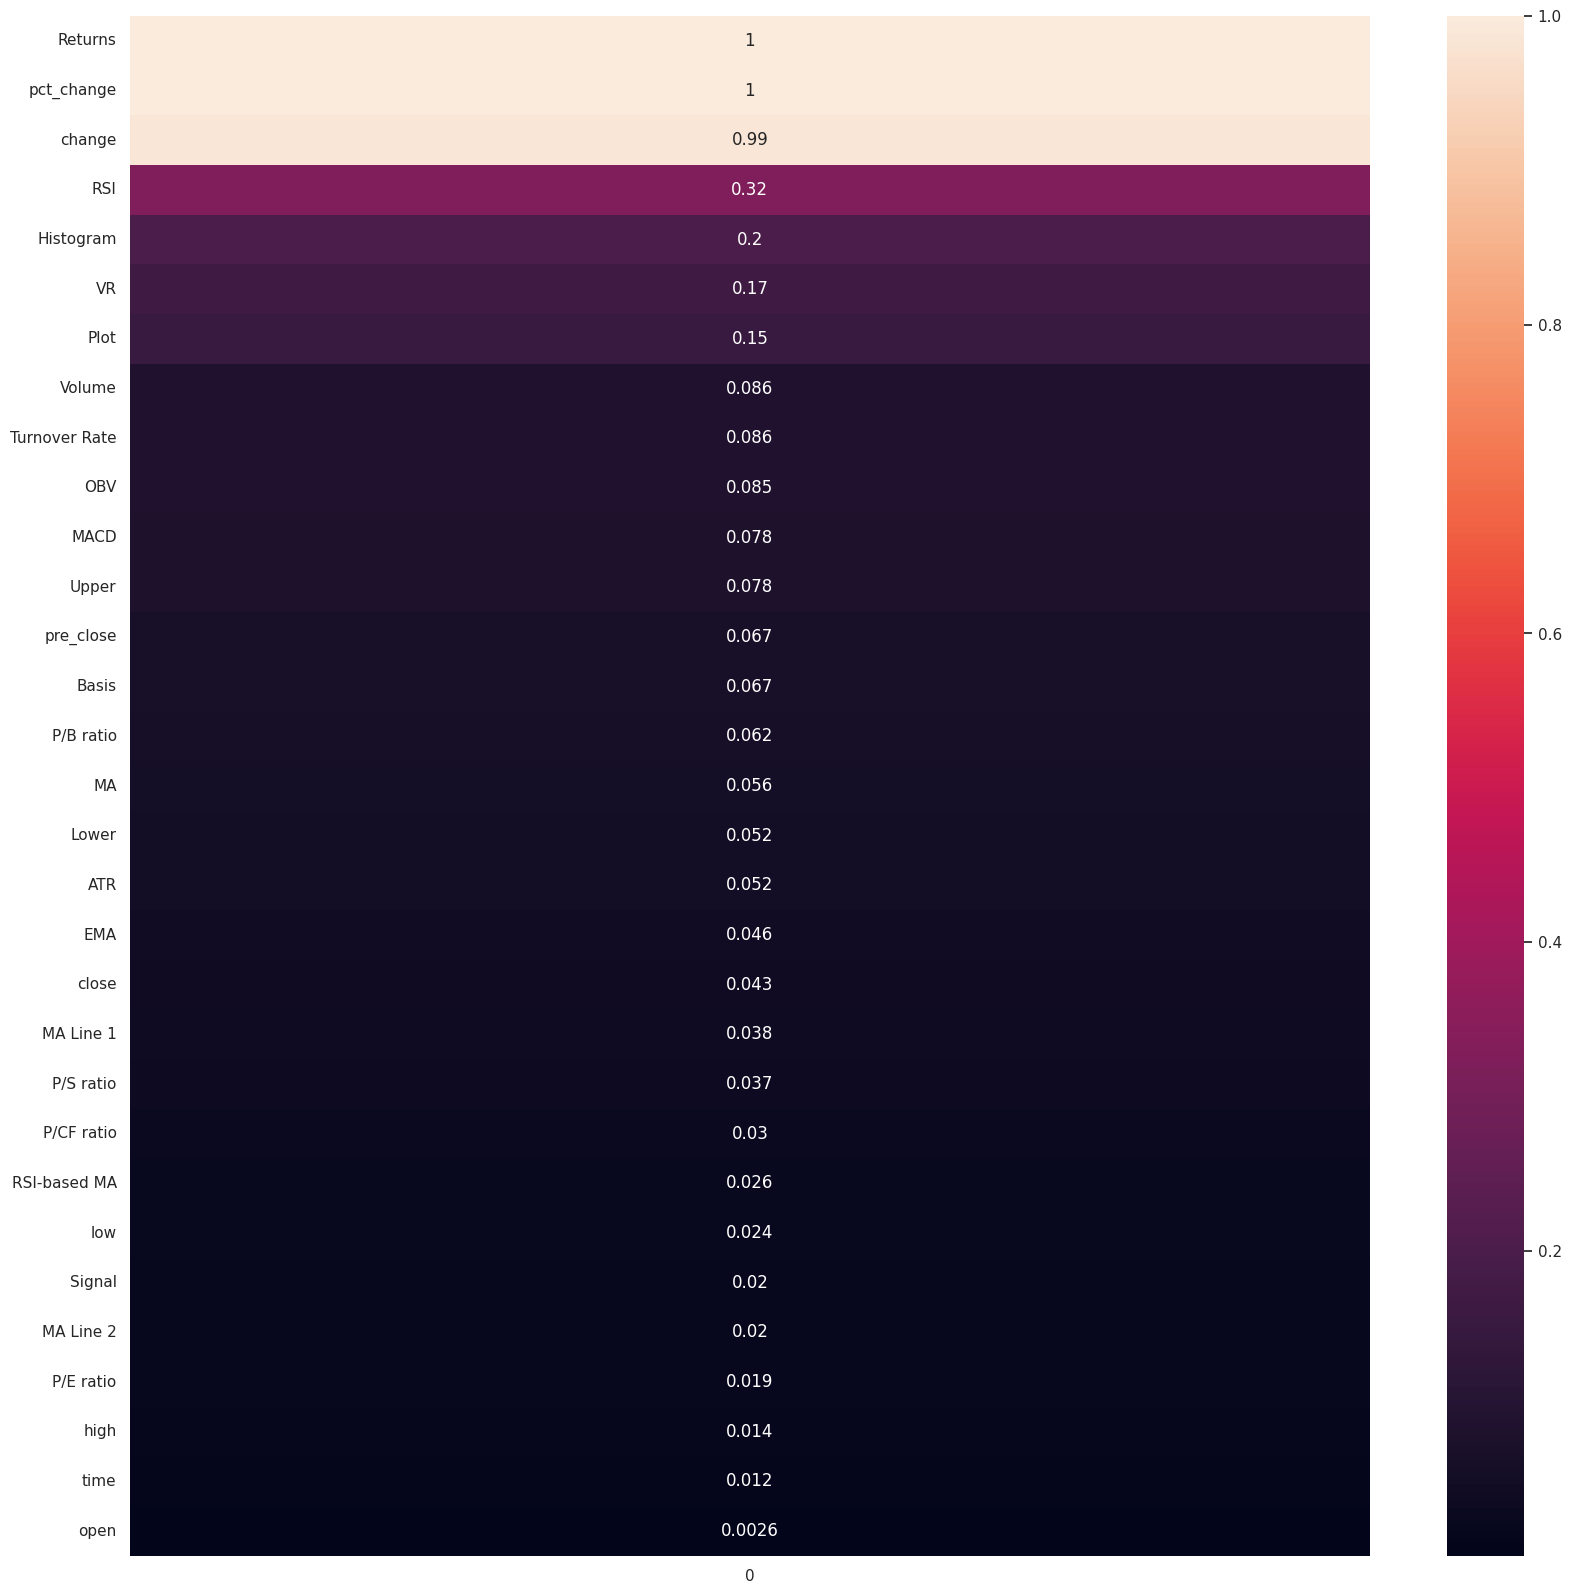

In [ ]:
Figure = plt.figure(figsize = (20,20))
Correlation = np.abs(Data.corr()["Returns"]).sort_values(ascending = False)
sns.heatmap(Correlation.values.reshape(-1,1), annot = True, yticklabels = Correlation.index)
plt.show()

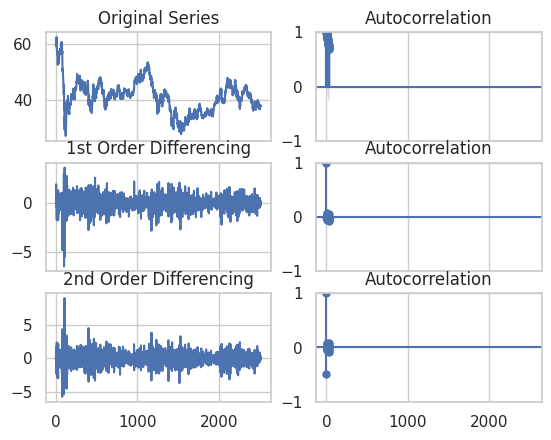

In [ ]:
#Determine the number of lags in the system
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(Data["close"].values); axes[0, 0].set_title('Original Series')
plot_acf(Data["close"].values, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(np.diff(Data["close"].values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(Data["close"].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(Data["close"].values))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(Data["close"].values)), ax=axes[2, 1])
plt.show()

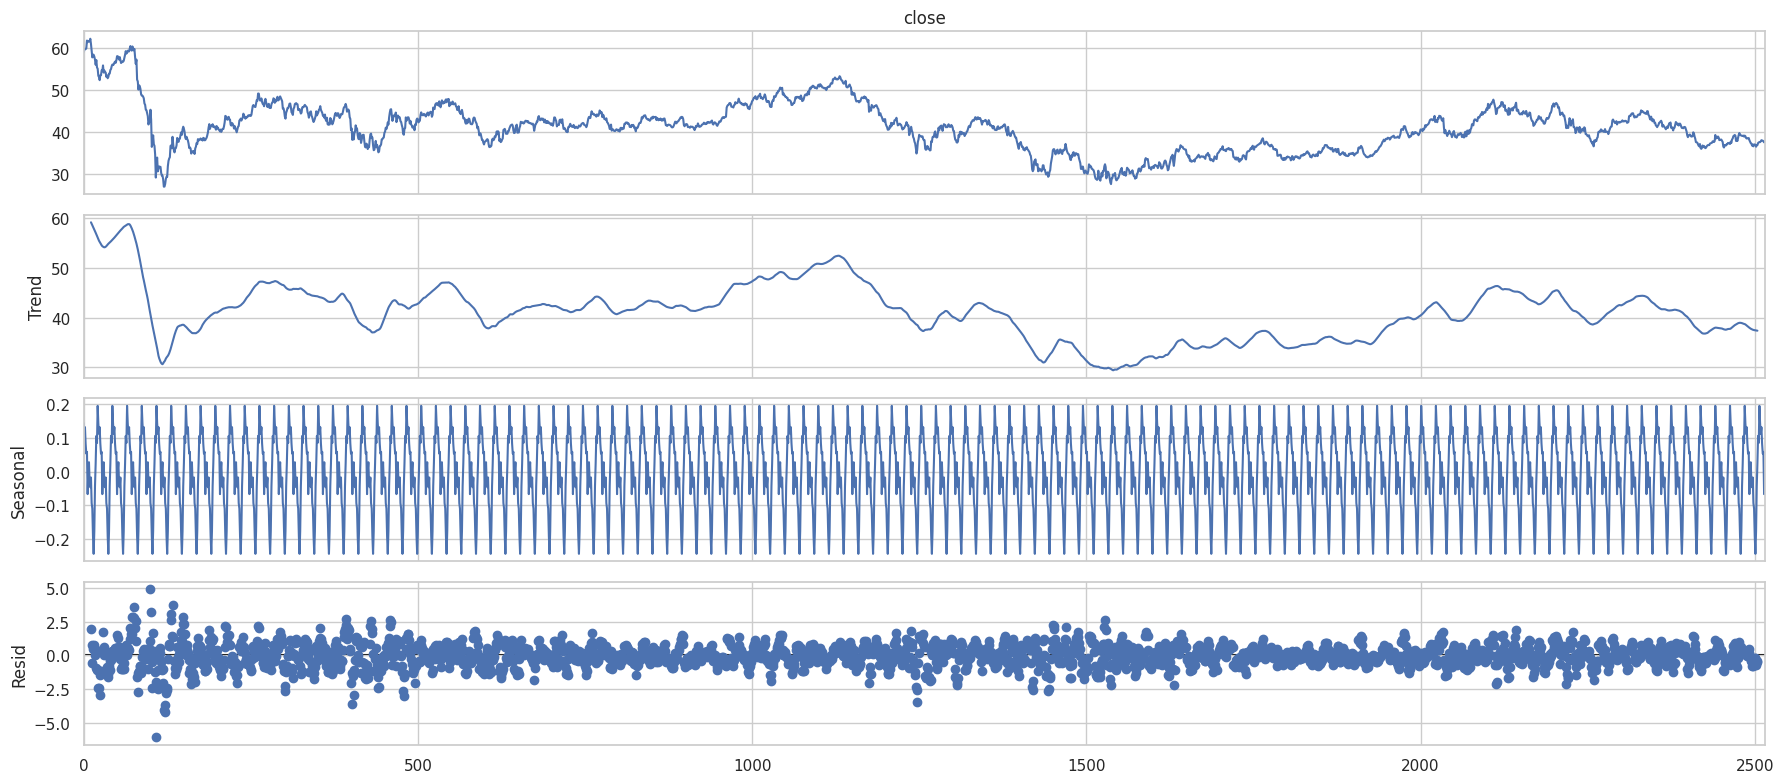

In [ ]:
# Plot the sesonal decomposition
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Data["close"].iloc[-10000:], model='additive', period = 22)
fig = decomposition.plot()
plt.tight_layout()
plt.show()

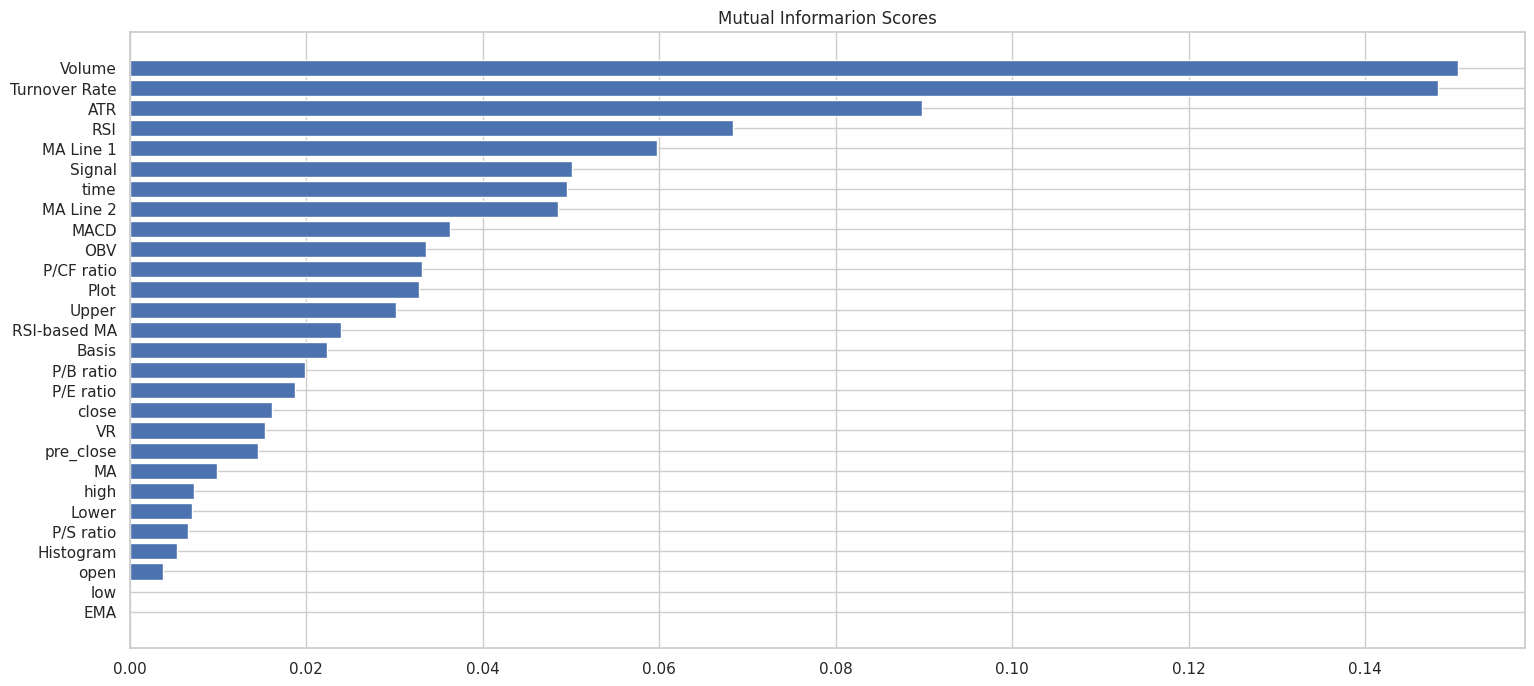

In [ ]:
Mi_Scores = make_mi_scores(Data.drop(columns = ["Returns", "pct_change", "change"]), Data["Returns"])
plot_mi_scores(Mi_Scores)

In [ ]:
def Compute_Volatility(Log_Garch_Dataset, rolling_window, buffer = 100, best_garch = None, best_figarch = None, best_harch = None, best_arch = None, interval = 7,
                      return_ticker = True):

        # Objective function for GARCH
    def Garch_Objective(params):
        p = int(params["p"])
        q = int(params["q"])
        dist = params["dist"]

        # Fit the GARCH model
        model = arch_model(log_returns, vol="Garch", p=p, q=q, dist=dist)

        try:
            tuned_model = model.fit(disp="off")
            aic = tuned_model.aic  # we can also use BIC: tuned_model.bic
        except:
            aic = np.inf  # In case the model fitting fails

        return {"loss": aic, "status": STATUS_OK}

    # Define the search space for GARCH
    space_garch = {
        "p": hp.choice("p", [1, 2, 3, 4, 5, 6]),  # ARCH lags
        "q": hp.choice("q", [1, 2, 3, 4, 5, 6]),  # GARCH lags
        "dist": hp.choice("dist", ["normal", "t"])
    }

    Garch_Space = {
        "p": [1, 2, 3, 4, 5, 6],
        "q": [1, 2, 3, 4, 5, 6],
        "dist": ["normal", "t"]
    }


    # Objective function for EGARCH
    def Egarch_Objective(params):
        p = int(params["p"])
        q = int(params["q"])
        dist = params["dist"]

        # Fit the EGARCH model
        model = arch_model(log_returns, vol="EGarch", p=p, q=q, dist=dist)

        try:
            tuned_model = model.fit(disp="off")
            aic = tuned_model.aic  # we can also use BIC: tuned_model.bic
        except:
            aic = np.inf

        return {"loss": aic, "status": STATUS_OK}

    # Define the search space for EGARCH
    space_egarch = {
        "p": hp.choice("p", [1, 2, 3, 4, 5, 6]),
        "q": hp.choice("q", [1, 2, 3, 4, 5, 6]),
        "dist": hp.choice("dist", ["normal", "t"])
    }


    EGarch_Space = {
        "p": [1, 2, 3, 4, 5, 6],
        "q": [1, 2, 3, 4, 5, 6],
        "dist": ["normal", "t"]
    }

    # Objective function for FIGARCH
    def Figarch_Objective(params):
        p = int(params["p"])
        q = int(params["q"])
        dist = params["dist"]

        # Fit the FIGARCH model
        model = arch_model(log_returns, vol="Figarch", p=p, q=q, dist=dist)

        try:
            tuned_model = model.fit(disp="off")
            aic = tuned_model.aic
        except:
            aic = np.inf

        return {"loss": aic, "status": STATUS_OK}

    # Define the search space for FIGARCH
    space_figarch = {
        "p": hp.choice("p", [0, 1]),  # FIGARCH generally uses low p and q
        "q": hp.choice("q", [0, 1]),
        "dist": hp.choice("dist", ["normal", "t"])
    }

    Figarch_Space = {
        "p": [0,1],
        "q": [0,1],
        "dist": ["normal", "t"]
    }

    # Objective function for HARCH
    def Harch_Objective(params):
        lags = params["lags"]
        dist = params["dist"]

        # Fit the HARCH model
        model = arch_model(log_returns, vol="Harch", lags=lags, dist=dist)

        try:
            tuned_model = model.fit(disp="off")
            aic = tuned_model.aic
        except:
            aic = np.inf

        return {"loss": aic, "status": STATUS_OK}

    # Define the search space for HARCH
    space_harch = {
        "lags": hp.choice("lags", [[1, 5], [1, 5, 22], [1, 5, 10, 22], [1,5,7,14,22,44]]),  # Different time horizons
        "dist": hp.choice("dist", ["normal", "t"])
    }

    Harch_Space = {
        "lags": [[1, 5], [1, 5, 22], [1, 5, 10, 22], [1,5,7,14,22,44]],
        "dist": ["normal", "t"]
    }

    def Arch_Objective(params):
        p = int(params["p"])
        dist = params["dist"]

        # Fit the ARCH model
        model = arch_model(log_returns, vol="Arch", p=p, dist=dist)

        try:
            tuned_model = model.fit(disp="off")
            aic = tuned_model.aic
        except:
            aic = np.inf

        return {"loss": aic, "status": STATUS_OK}

    # Define the search space for ARCH
    space_arch = {
        "p": hp.choice("p", [1, 2, 3, 4, 5, 6]),
        "dist": hp.choice("dist", ["normal", "t"])
    }

    Arch_Space = {
        "p": [1, 2, 3, 4, 5, 6],
        "dist": ["normal", "t"]
    }
    log_returns = Log_Garch_Dataset["close_volatility"]
    # Run Hyperopt for GARCH:
    if best_garch is None:
        trials_garch = Trials()
        best_garch = fmin(fn=Garch_Objective,
                       space=space_garch,
                       algo=tpe.suggest,
                       max_evals=100,
                       trials=trials_garch)
        return_ticker = True

    rolling_forecast = []
    Lister = 0
    for index in tqdm(range(buffer, len(Log_Garch_Dataset), interval)):
        #print(f"Index: {index}, Forecasting {interval} steps ahead.")
        Garch_Model = arch_model(log_returns[:index], vol = "Garch", p = Garch_Space["p"][best_garch["p"]], q = Garch_Space["q"][best_garch["q"]], dist = Garch_Space["dist"][best_garch["dist"]])
        Garch_Fit = Garch_Model.fit(disp = "off")
        Forecast = Garch_Fit.forecast(horizon = interval)
        #print(Forecast.variance.shape)
        for step in range(1, interval + 1):
            if interval >= 10:
                column_name = f'h.{step:02d}'# Correct column format, e.g., 'h.01', 'h.02', etc.
            else:
                column_name = f"h.{step}"
            #print(column_name, Forecast.variance.columns)
            # Ensure the column exists before accessing
            if column_name in Forecast.variance.columns and index + step <= len(Log_Garch_Dataset):
                # Safely access the variance for this forecast step and convert to volatility
                Forecasted_Volatility = Forecast.variance[column_name].iloc[-1]**0.5
                #print(1)
                rolling_forecast.append(Forecasted_Volatility)
            elif column_name in Forecast.variance.columns and not index+step <= len(Log_Garch_Dataset):
                #print(2)
                continue
            else:
                #print(3)
                rolling_forecast.append(Forecasted_Volatility)


    #print(f"Length of Log_Garch_Dataset: {len(Log_Garch_Dataset)}")
    #print(f"Length of rolling_forecast: {len(rolling_forecast)}")
    rolling_forecast = [np.nan] * buffer + rolling_forecast
    Log_Garch_Dataset["predicted_garch_volatility"] = rolling_forecast


    # Run Hyperopt for FIGARCH
    if best_figarch is None:
        trials_figarch = Trials()
        best_figarch = fmin(fn=Figarch_Objective,
                        space=space_figarch,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials_figarch)

    rolling_forecast = []
    for index in tqdm(range(buffer, len(Log_Garch_Dataset), interval)):
        FGarch_Model = arch_model(log_returns[:index], vol = "Figarch", p = Figarch_Space["p"][best_figarch["p"]], q = Figarch_Space["q"][best_figarch["q"]], dist = Figarch_Space["dist"][best_figarch["dist"]])
        FGarch_Fit = FGarch_Model.fit(disp = "off")
        Forecast = FGarch_Fit.forecast(horizon = interval)
        #print(Forecast.variance.shape)
        for step in range(1, interval + 1):
            if interval >= 10:
                column_name = f'h.{step:02d}'# Correct column format, e.g., 'h.01', 'h.02', etc.
            else:
                column_name = f"h.{step}"
            #print(column_name, Forecast.variance.columns)
            # Ensure the column exists before accessing
            if column_name in Forecast.variance.columns and index + step <= len(Log_Garch_Dataset):
                # Safely access the variance for this forecast step and convert to volatility
                Forecasted_Volatility = Forecast.variance[column_name].iloc[-1]**0.5
                #print(1)
                rolling_forecast.append(Forecasted_Volatility)
            elif column_name in Forecast.variance.columns and not index+step <= len(Log_Garch_Dataset):
                #print(2)
                continue
            else:
                #print(3)
                rolling_forecast.append(Forecasted_Volatility)

    rolling_forecast = [np.nan] * buffer + rolling_forecast
    Log_Garch_Dataset["predicted_fgarch_volatility"] = rolling_forecast


    # Run Hyperopt for HARCH
    if best_harch is None:
        trials_harch = Trials()
        best_harch = fmin(fn=Harch_Objective,
                      space=space_harch,
                      algo=tpe.suggest,
                      max_evals=100,
                      trials=trials_harch)

    rolling_forecast = []
    for index in tqdm(range(buffer, len(Log_Garch_Dataset), interval)):
        HGarch_Model = arch_model(log_returns[:index], vol = "Harch", lags = Harch_Space["lags"][best_harch["lags"]], dist = Harch_Space["dist"][best_harch["dist"]])
        HGarch_Fit = HGarch_Model.fit(disp = "off")
        Forecast = HGarch_Fit.forecast(horizon = interval)
        #print(Forecast.variance.shape)
        for step in range(1, interval + 1):
            if interval >= 10:
                column_name = f'h.{step:02d}'# Correct column format, e.g., 'h.01', 'h.02', etc.
            else:
                column_name = f"h.{step}"
            #print(column_name, Forecast.variance.columns)
            # Ensure the column exists before accessing
            if column_name in Forecast.variance.columns and index + step <= len(Log_Garch_Dataset):
                # Safely access the variance for this forecast step and convert to volatility
                Forecasted_Volatility = Forecast.variance[column_name].iloc[-1]**0.5
                #print(1)
                rolling_forecast.append(Forecasted_Volatility)
            elif column_name in Forecast.variance.columns and not index+step <= len(Log_Garch_Dataset):
                #print(2)
                continue
            else:
                #print(3)
                rolling_forecast.append(Forecasted_Volatility)

    rolling_forecast = [np.nan] * buffer + rolling_forecast
    Log_Garch_Dataset["predicted_hgarch_volatility"] = rolling_forecast

    # Run Hyperopt for ARCH
    if best_arch is None:
        trials_arch = Trials()
        best_arch = fmin(fn=Arch_Objective,
                     space=space_arch,
                     algo=tpe.suggest,
                     max_evals=100,
                     trials=trials_arch)

    rolling_forecast = []
    for index in tqdm(range(buffer, len(Log_Garch_Dataset), interval)):
        Aarch_Model = arch_model(log_returns[:index], vol = "Arch", lags = Arch_Space["p"][best_arch["p"]], dist = Harch_Space["dist"][best_arch["dist"]])
        Aarch_Fit = Aarch_Model.fit(disp = "off")
        Forecast = Aarch_Fit.forecast(horizon = interval)
        #print(Forecast.variance.shape)
        for step in range(1, interval + 1):
            if interval >= 10:
                column_name = f'h.{step:02d}'# Correct column format, e.g., 'h.01', 'h.02', etc.
            else:
                column_name = f"h.{step}"
            #print(column_name, Forecast.variance.columns)
            # Ensure the column exists before accessing
            if column_name in Forecast.variance.columns and index + step <= len(Log_Garch_Dataset):
                # Safely access the variance for this forecast step and convert to volatility
                Forecasted_Volatility = Forecast.variance[column_name].iloc[-1]**0.5
                #print(1)
                rolling_forecast.append(Forecasted_Volatility)
            elif column_name in Forecast.variance.columns and not index+step <= len(Log_Garch_Dataset):
                #print(2)
                continue
            else:
                #print(3)
                rolling_forecast.append(Forecasted_Volatility)

    rolling_forecast = [np.nan] * buffer + rolling_forecast
    Log_Garch_Dataset["predicted_Aarch_volatility"] = rolling_forecast

    if return_ticker:
        return Log_Garch_Dataset[["predicted_garch_volatility", "predicted_fgarch_volatility", "predicted_hgarch_volatility", "predicted_Aarch_volatility"]], best_garch, best_figarch, best_harch, best_arch
    else:
        return Log_Garch_Dataset[["predicted_garch_volatility", "predicted_fgarch_volatility", "predicted_hgarch_volatility", "predicted_Aarch_volatility"]]


In [ ]:
def rolling_min_max_normalisation(series, window):
    return (series - series.rolling(window=window, min_periods=1).min()) / \
           (series.rolling(window=window, min_periods=1).max() - series.rolling(window=window, min_periods=1).min() + 1e-6)

def min_max_normalization(series, context=None):
    if context is not None:
        expanding_min = context[0]
        expanding_max = context[1] + 1e-6
    else:
        expanding_min = series.min()
        expanding_max = series.max() + 1e-6  # Adding small epsilon to avoid division by zero

    return (series - expanding_min) / (expanding_max - expanding_min), expanding_min, expanding_max

def rolling_z_score_scaler(series, window):
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std() + 1e-6
    return (series - rolling_mean) / rolling_std

def standard_z_score_norm(series, context = None):
    if context is not None:
        mean = context[0]
        std = context[1]
    else:
        mean = series.mean()
        std = series.std() + 1e-6

    return (series - mean)/(std), mean, std

In [ ]:
def Feature_Engineering(file_name, sliding_window, validation_split, buffer):
    Data = pd.read_csv(file_name, parse_dates=['time']).dropna()

    # Extract the Dataset
    Data = Data[["time","open", "close", "high", "low", "Upper", "Lower", "Volume", "Turnover Rate", "ATR", "MA Line 1", "Signal", "MA Line 2", "MACD", "P/CF ratio", "EMA", "Basis", "Plot", "OBV"]]
    X,y = pd.DataFrame(), pd.DataFrame()

    Data["time"] = pd.to_datetime(Data["time"], format = "%d-%m-%Y")
    Data["weekday"] = Data["time"].dt.weekday
    Data["year"] = Data["time"].dt.year
    Data["month"] = Data["time"].dt.month
    Data["day"] = Data["time"].dt.day

    # Generate the Targets:
    y["returns"] = np.log(Data["close"] + 1e-6).diff().fillna(method = "bfill")
    y["close"] = Data['close']
    y["high"] = Data["high"]
    y["low"] = Data["low"]
    y["close"] = y["close"].fillna(method = "bfill")
    y["low"] = y["low"].fillna(method = "bfill")
    y["high"] = y["high"].fillna(method = "bfill")

    # Generate the Dates:
    X["weekday"] = Data["weekday"].fillna(method = "bfill")
    X["year"] = Data["year"].fillna(method = "bfill")
    X["month"] = Data["month"].fillna(method = "bfill")
    X["day"] = Data["day"].fillna(method = "bfill")

    # Generate the Original Features
    X["returns"] = y["returns"].fillna(method = "bfill")
    X["close"] = Data["close"].fillna(method = "bfill")
    X["open"] = Data["open"].fillna(method = "bfill")
    X["high"] = Data["high"].fillna(method = "bfill")
    X["low"] = Data["low"].fillna(method = "bfill")

    # Apply Some Feature Engineering:
    X[f"returns_{sliding_window}"] = y["returns"].rolling(sliding_window).mean().fillna(method = "bfill")
    X[f"returns_{sliding_window//2}"] = y["returns"].rolling(sliding_window//2).mean().fillna(method = "bfill")
    X[f"close_{sliding_window}"] = X["close"].rolling(24).mean().fillna(method = "bfill")
    X[f"close_{sliding_window}"] = X["close"].rolling(60).mean().fillna(method = "bfill")

    # Relative Returns Normalization
    X['open_rel'] = np.log(Data['open'] / Data['close'].shift(1))
    X['high_rel'] = np.log(Data['high'] / Data['close'].shift(1))
    X['low_rel'] = np.log(Data['low'] / Data['close'].shift(1))

    X[f"returns_{sliding_window-sliding_window//2}"] = X[f"returns_{sliding_window}"] -  X[f"returns_{sliding_window//2}"]
    X["Upper_Shadow"] = X["high"] - np.maximum(X["close"], X["open"])
    X["Lower_Shadow"] = X["low"] - np.minimum(X["close"], X["open"])

    X[f"Support_Level{sliding_window}"] = X["close"].rolling(sliding_window).min()
    X[f"Resistance_Level{sliding_window}"] = X["close"].rolling(sliding_window).max()

    X["upper_band"], X["middle_band"], X["lower_band"] = ta.BBANDS(X["close"])

    Decomposition = sm.tsa.seasonal_decompose(X["close"], model = "additive", period = sliding_window, two_sided = False)
    X["Trend"] = Decomposition.trend
    X["Seasonal"] = Decomposition.seasonal
    X["Residual"] = Decomposition.resid

    X["Volume"] = np.log(Data["Volume"] + 1e-6)
    X["Turnover Rate"] = np.log(Data["Turnover Rate"] + 1e-6)
    X["ATR"] = np.log(Data["ATR"] + 1e-6)
    X["MA Line 1"] = np.log(Data["MA Line 1"] + 1e-6)
    X["MA Line 2"] = np.log(Data["MA Line 2"] + 1e-6)
    X["Signal"] = Data["Signal"]
    X["MACD"] = Data["MACD"]
    X["P/CF ratio"] = Data["P/CF ratio"]
    X["Plot"] = Data["Plot"]
    X["OBV"] = np.log(Data["OBV"])
    X["EMA"] = Data["EMA"]
    X["Basis"] = Data["Basis"]
    X["Upper"] = Data["Upper"]
    X["Lower"] = Data["Lower"]

    X_Train, y_Train, X_Val, y_Val = X.iloc[:int(validation_split*len(X))], y.iloc[:int(validation_split*len(y))], X.iloc[int(validation_split*len(X)):], y.iloc[int(validation_split*len(y)):]

    # Compute the Volatility:
    Garch_Dataset = X_Train[["close", "open", "low", "high"]]
    Log_Garch_Dataset = np.log(Garch_Dataset + 1e-6).diff().fillna(method = "bfill")
    Log_Garch_Dataset[["open_volatility", "close_volatility", "low_volatility", "high_volatility"]] = Log_Garch_Dataset.rolling(window = 22, center = False).std()
    Log_Garch_Dataset = Log_Garch_Dataset * (252**0.5)
    Log_Garch_Dataset = Log_Garch_Dataset.replace([np.inf, -np.inf], np.nan).fillna(method = "bfill")
    log_returns = Log_Garch_Dataset["close_volatility"]

    X_Train_Garch_Dataset, best_garch, best_figarch, best_harch, best_arch = Compute_Volatility(Log_Garch_Dataset, sliding_window, return_ticker = True)
    X_Train = pd.concat([X_Train, X_Train_Garch_Dataset], axis = 1)
    X_Train.dropna(inplace = True)
    y_Train = y_Train.iloc[buffer:]

    Garch_Dataset = X_Val[["close", "open", "low", "high"]]
    Log_Garch_Dataset = np.log(Garch_Dataset + 1e-6).diff().fillna(method = "bfill")
    Log_Garch_Dataset[["open_volatility", "close_volatility", "low_volatility", "high_volatility"]] = Log_Garch_Dataset.rolling(window = 22, center = False).std()
    Log_Garch_Dataset = Log_Garch_Dataset * (252**0.5)
    Log_Garch_Dataset = Log_Garch_Dataset.replace([np.inf, -np.inf], np.nan).fillna(method = "bfill")
    log_returns = Log_Garch_Dataset["close_volatility"]

    X_Val_Garch_Dataset = Compute_Volatility(Log_Garch_Dataset, sliding_window, buffer, best_garch, best_figarch, best_harch, best_arch, return_ticker = False)
    X_Val = pd.concat([X_Val, X_Val_Garch_Dataset], axis = 1)
    X_Val.dropna(inplace = True)
    y_Val = y_Val.iloc[buffer:]

    Datetime_Features = ["weekday", "year", "month", "day"]
    X_Train_Normalised = X_Train.copy()
    X_Val_Normalised = X_Val.copy()

    X_Train_Normalised.iloc[:,4:], x_min, x_max = min_max_normalization(X_Train.iloc[:,4:])
    X_Val_Normalised.iloc[:,4:], _, _ = min_max_normalization(X_Val.iloc[:,4:], [x_min, x_max])

    return X_Train_Normalised, y_Train, X_Val_Normalised, y_Val, x_min, x_max

In [ ]:
X_Train, y_Train, X_Val, y_Val, x_min, x_max = Feature_Engineering('/content/stock_dataset.csv', 22, 0.8, 100)
X_Train.shape, y_Train.shape, X_Val.shape, y_Val.shape, x_min.shape, x_max.shape

 19%|█▉        | 19/100 [00:01<00:04, 17.19trial/s, best loss: -5783.739395644736]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





 25%|██▌       | 25/100 [00:02<00:07,  9.96trial/s, best loss: -5783.739395644736]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.





 47%|████▋     | 47/100 [00:05<00:05,  9.90trial/s, best loss: -5783.739395644736]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





 61%|██████    | 61/100 [00:07<00:04,  8.05trial/s, best loss: -5783.739395644736]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





 79%|███████▉  | 79/100 [00:09<00:02,  7.33trial/s, best loss: -5783.739395644736]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.





 96%|█████████▌| 96/100 [00:11<00:00,  9.59trial/s, best loss: -5783.739395644736]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





100%|██████████| 100/100 [00:12<00:00,  7.82trial/s, best loss: -5783.739395644736]


  0%|          | 1/274 [00:00<00:43,  6.32it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


  2%|▏         | 5/274 [00:00<00:30,  8.90it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


  5%|▍         | 13/274 [00:01<00:28,  9.31it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


  5%|▌         | 15/274 [00:01<00:29,  8.71it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

 11%|█         | 11/100 [00:04<00:42,  2.09trial/s, best loss: -5789.930303160095]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





 18%|█▊        | 18/100 [00:07<00:29,  2.78trial/s, best loss: -5789.930303160095]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





 39%|███▉      | 39/100 [00:15<00:25,  2.41trial/s, best loss: -5789.930303160095]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.





100%|██████████| 100/100 [00:39<00:00,  2.54trial/s, best loss: -5789.930303160095]


100%|██████████| 274/274 [00:34<00:00,  7.92it/s]

  1%|          | 1/100 [00:00<00:12,  7.63trial/s, best loss: -5788.401458184784]

100%|██████████| 100/100 [00:10<00:00,  9.46trial/s, best loss: -5788.401458184784]


  0%|          | 1/274 [00:00<00:41,  6.58it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


  1%|          | 3/274 [00:00<00:22, 12.31it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


  3%|▎         | 8/274 [00:00<00:18, 14.30it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.


  4%|▎         | 10/274 [00:00<00:27,  9.49it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit r

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:06<00:00, 14.75trial/s, best loss: -5780.623565018312]


  1%|          | 2/274 [00:00<00:36,  7.38it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


  2%|▏         | 6/274 [00:00<00:27,  9.73it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.


  3%|▎         | 8/274 [00:01<00:43,  6.08it/s]/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.


  3

((1912, 43), (1912, 4), (404, 43), (404, 4), (39,), (39,))

In [ ]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, 100 to 2011
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   weekday                      1912 non-null   int32  
 1   year                         1912 non-null   int32  
 2   month                        1912 non-null   int32  
 3   day                          1912 non-null   int32  
 4   returns                      1912 non-null   float64
 5   close                        1912 non-null   float64
 6   open                         1912 non-null   float64
 7   high                         1912 non-null   float64
 8   low                          1912 non-null   float64
 9   returns_22                   1912 non-null   float64
 10  returns_11                   1912 non-null   float64
 11  close_22                     1912 non-null   float64
 12  open_rel                     1912 non-null   float64
 13  high_rel             

In [ ]:
y_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, 100 to 2011
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  1912 non-null   float64
 1   close    1912 non-null   float64
 2   high     1912 non-null   float64
 3   low      1912 non-null   float64
dtypes: float64(4)
memory usage: 74.7 KB


<Figure size 5000x5000 with 0 Axes>

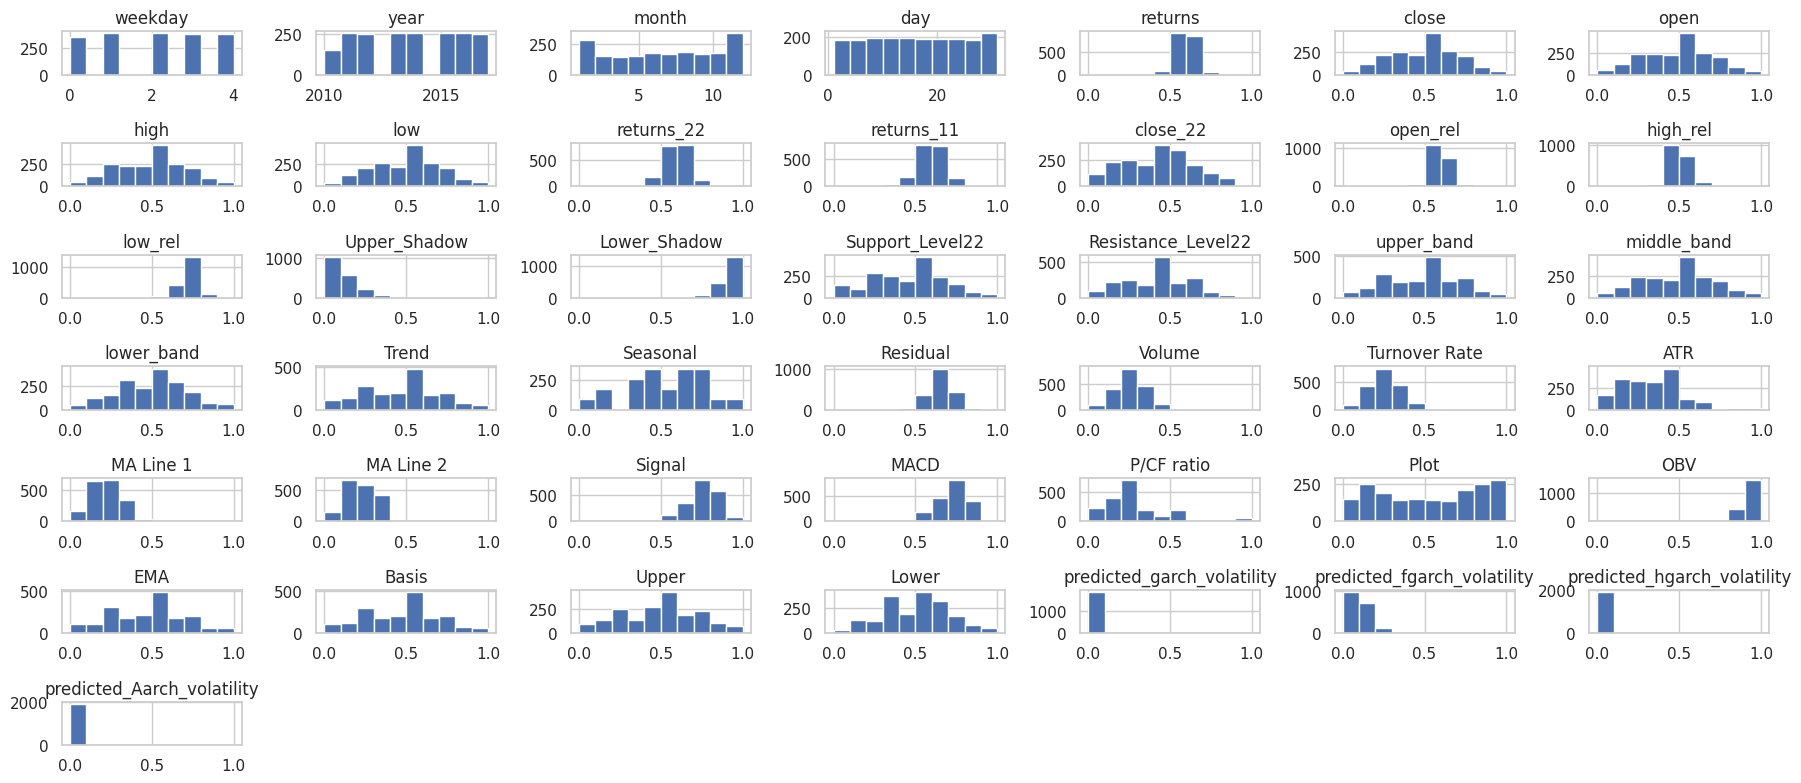

In [ ]:
Figure = plt.figure(figsize = (50,50))
X_Train.hist()
plt.tight_layout()
plt.show()

<Figure size 5000x5000 with 0 Axes>

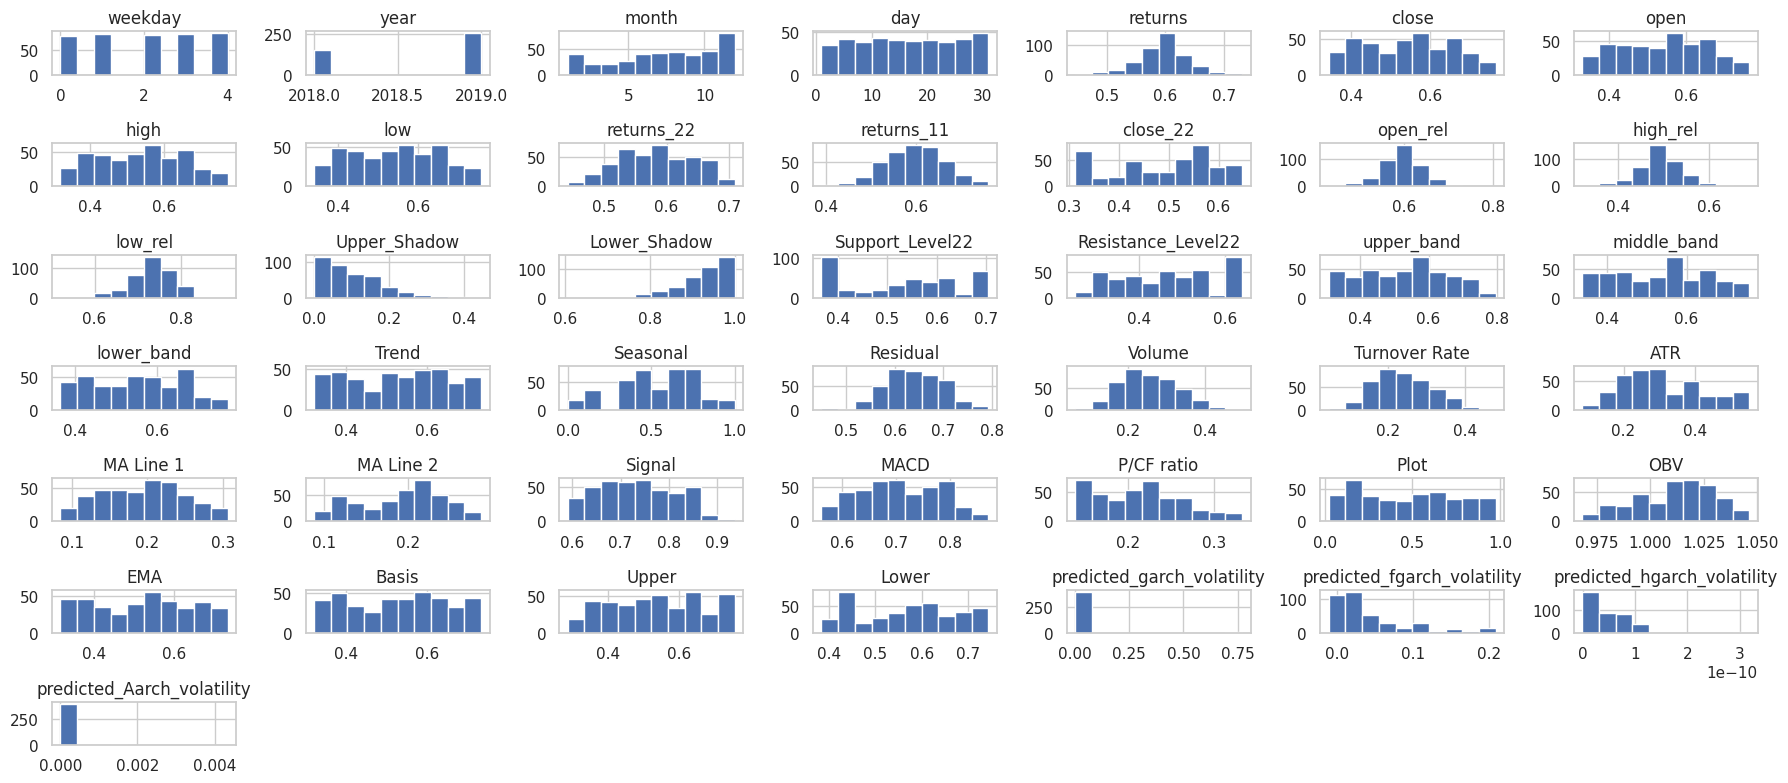

In [ ]:
Figure = plt.figure(figsize = (50,50))
X_Val.hist()
plt.tight_layout()
plt.show()

<Figure size 1000x10000 with 0 Axes>

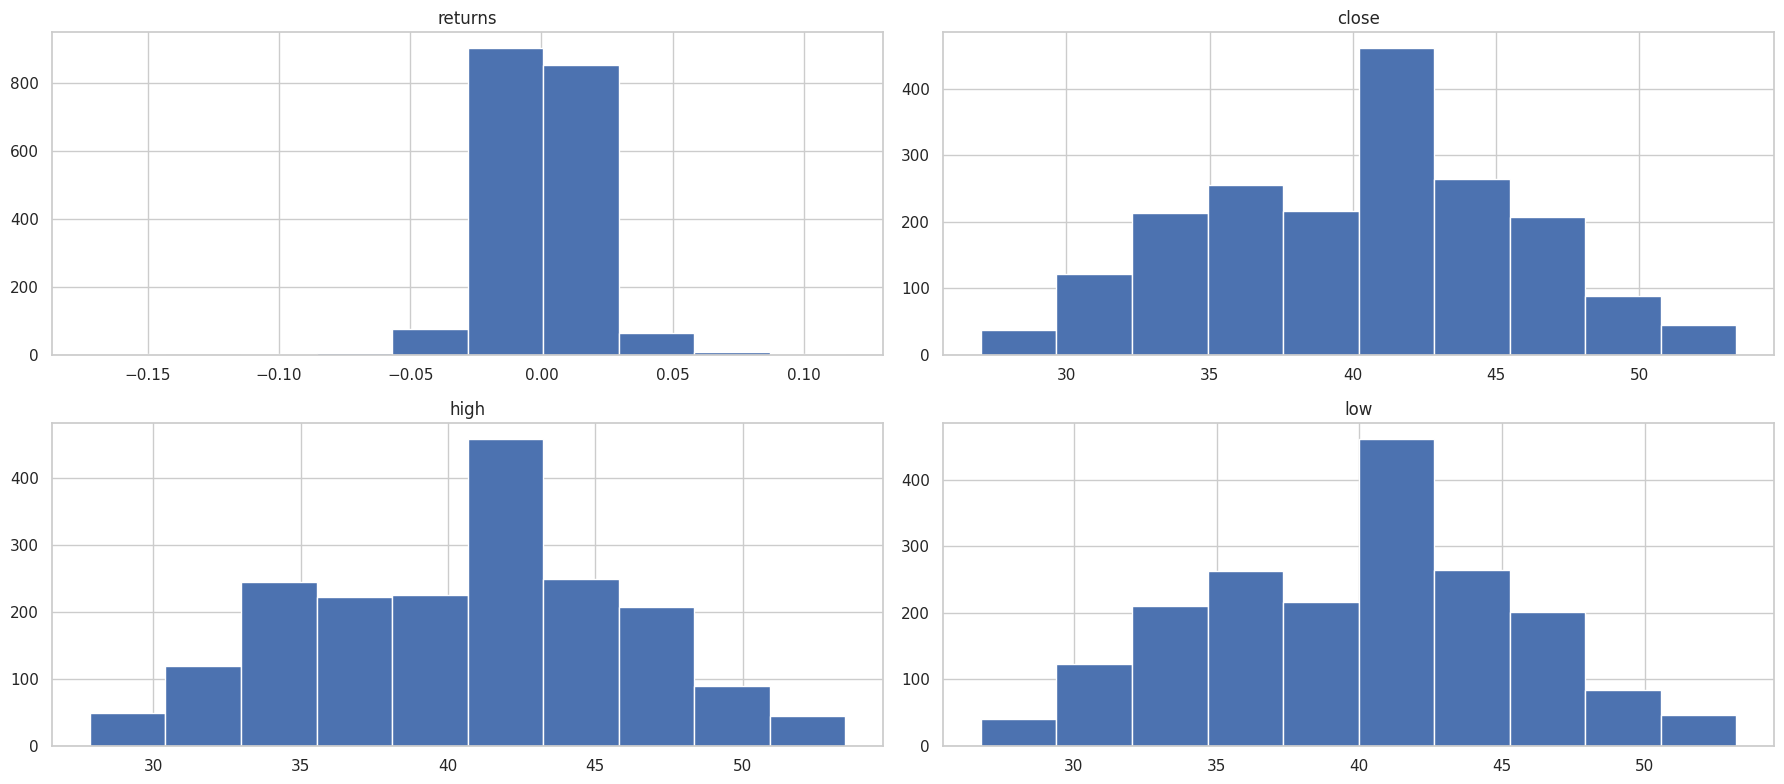

In [ ]:
Figure = plt.figure(figsize = (10,100))
y_Train.hist()
plt.tight_layout()
plt.show()

(0.0, 1.0)

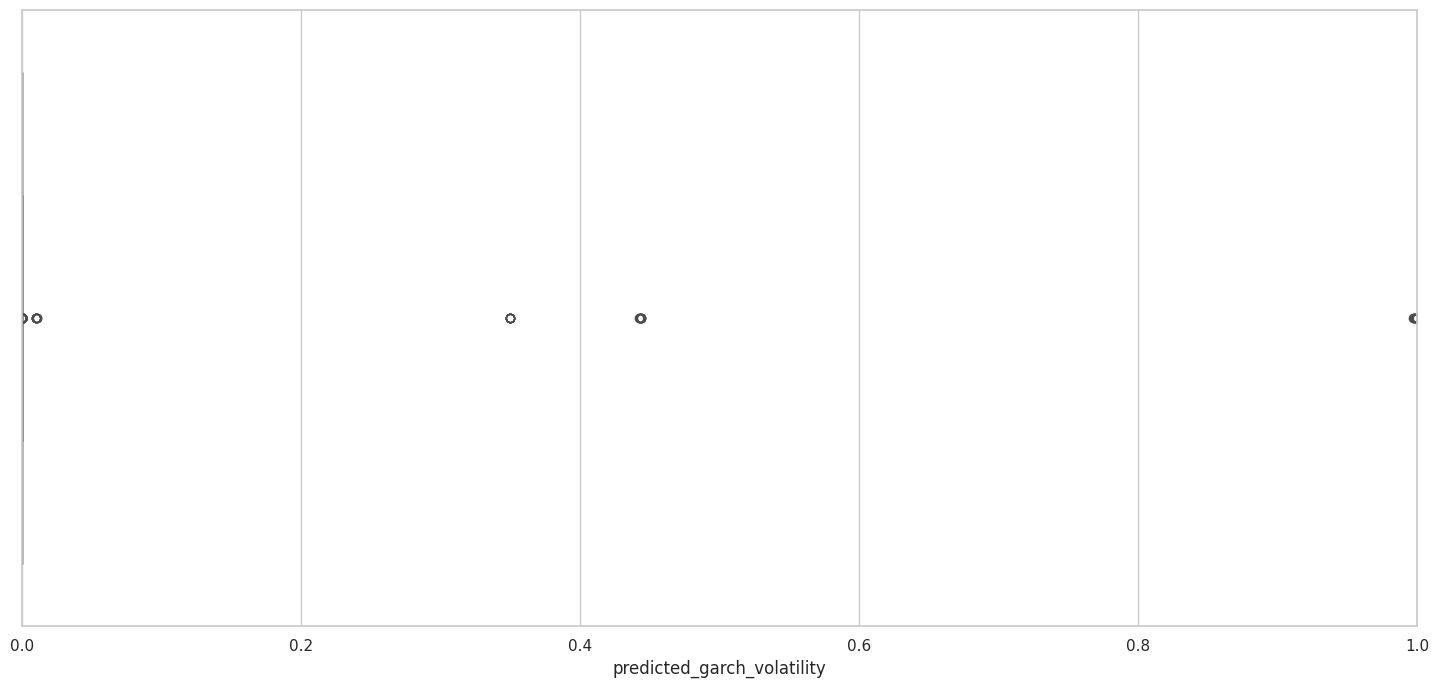

In [ ]:
sns.boxplot(data = X_Train, x = "predicted_garch_volatility")
plt.xlim(0,1)

(0.0, 1.0)

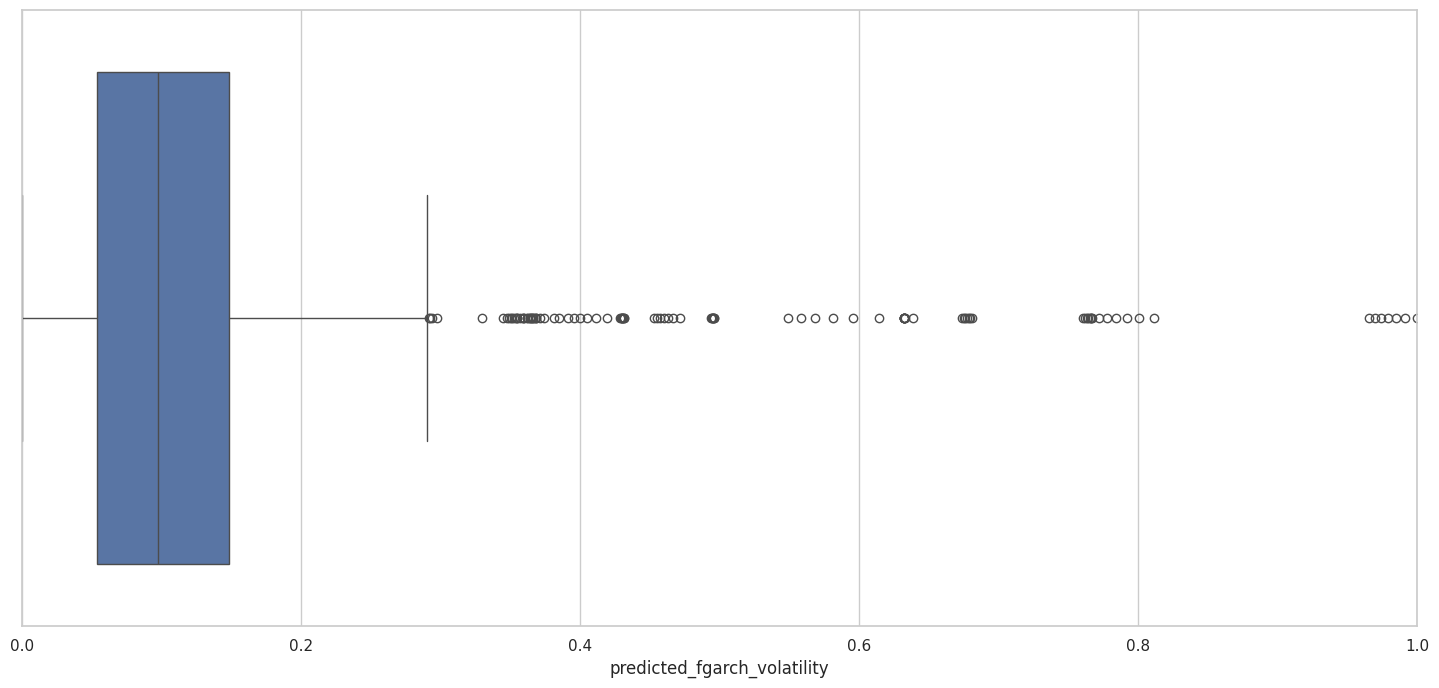

In [ ]:
sns.boxplot(data = X_Train, x = "predicted_fgarch_volatility")
plt.xlim(0,1)

(0.0, 1.0)

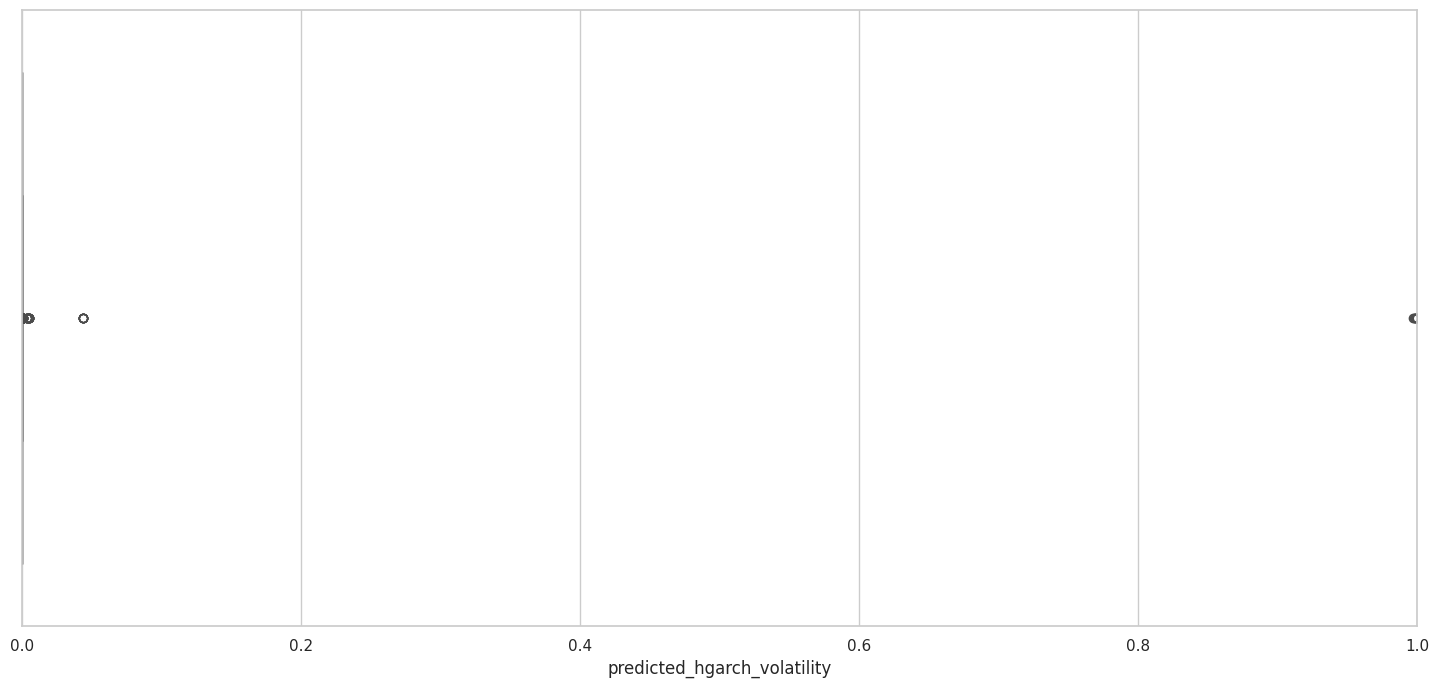

In [ ]:
sns.boxplot(data = X_Train, x = "predicted_hgarch_volatility")
plt.xlim(0,1)

(0.0, 1.0)

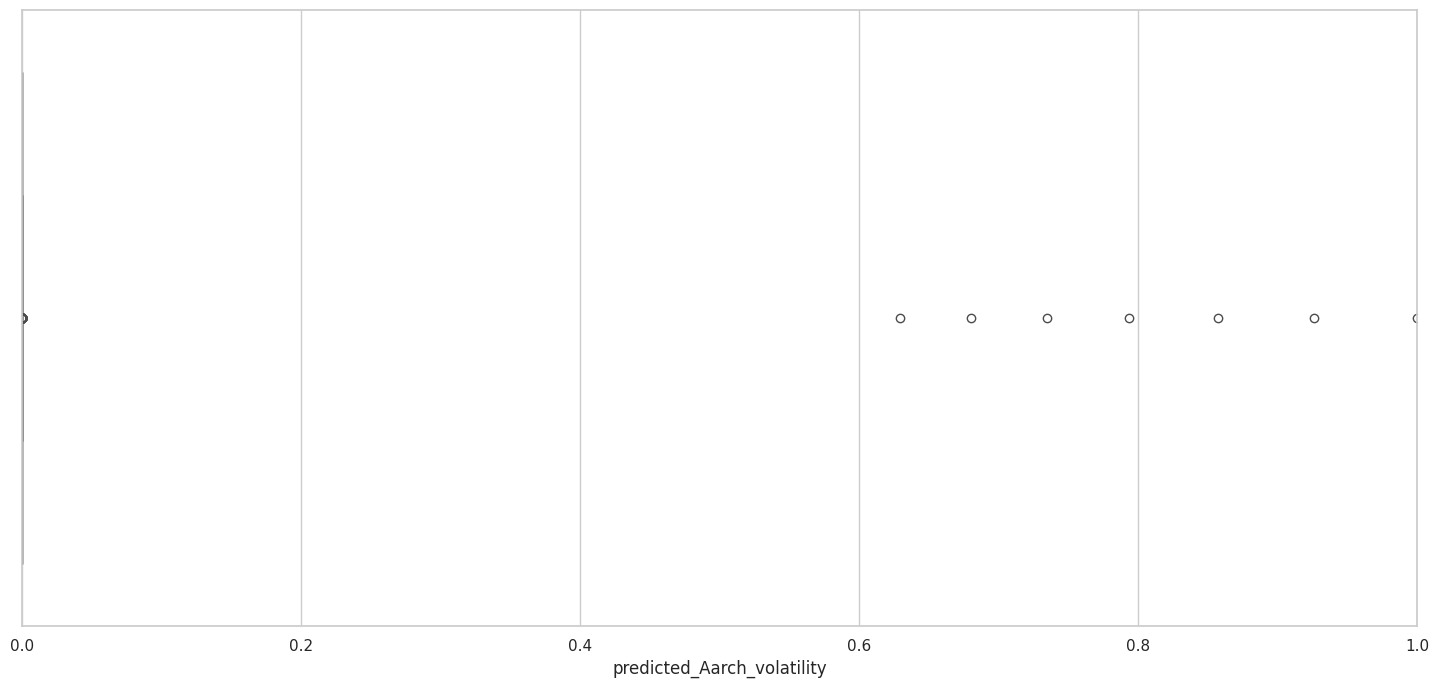

In [ ]:
sns.boxplot(data = X_Train, x = "predicted_Aarch_volatility")
plt.xlim(0,1)

In [ ]:
Train_X, Train_y = X_Train, y_Train
Train_X.shape, Train_y.shape

((1912, 43), (1912, 4))

In [ ]:
Valid_X, Valid_y = X_Val, y_Val
Valid_X.shape, Valid_y.shape

((404, 43), (404, 4))

In [ ]:
def create_rolling_windows(data_X, data_y, window_size, prediction_horizon, n_steps):

    X,y = [], []
    data_values = data_X.values
    target_values = data_y.values
    print(data_X.shape, data_y.shape)
    print(len(data_X) - window_size - prediction_horizon - n_steps +1)
    for index in range(len(data_X) - window_size - prediction_horizon - n_steps +1):
        #print(index)
        window = data_values[index:index+window_size, :]
        X.append(window)

        target = target_values[index + window_size + prediction_horizon -1: index + window_size + prediction_horizon - 1 + n_steps, :]
        #print(target.shape)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    return X,y

In [ ]:
X_train_3d, y_train_3d = create_rolling_windows(Train_X, Train_y, 22, 1, 1)
X_train_3d.shape, y_train_3d.shape

(1912, 43) (1912, 4)
1889


((1889, 22, 43), (1889, 1, 4))

In [ ]:
X_valid_3d, y_valid_3d = create_rolling_windows(Valid_X, Valid_y, 22, 1, 1)
X_valid_3d.shape, y_valid_3d.shape

(404, 43) (404, 4)
381


((381, 22, 43), (381, 1, 4))

In [ ]:
X_train_tensor = torch.tensor(X_train_3d, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_3d, dtype = torch.float32)
y_train_tensor = y_train_tensor.squeeze(1)
X_valid_tensor = torch.tensor(X_valid_3d, dtype = torch.float32)
y_valid_tensor = torch.tensor(y_valid_3d, dtype = torch.float32)
y_valid_tensor = y_valid_tensor.squeeze(1)

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(self.X.shape)
        return self.X[idx, :, 4:], self.y[idx], idx

    def __getdate__(self, idx):
        return self.X[idx, :, :4]

Train_Dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
Valid_Dataset = TimeSeriesDataset(X_valid_tensor, y_valid_tensor)

Train_Loader = torch.utils.data.DataLoader(Train_Dataset, batch_size = 32, shuffle = True)
Validation_Loader = torch.utils.data.DataLoader(Valid_Dataset, batch_size = 32, shuffle = False)

len(Train_Loader), len(Validation_Loader)

(60, 12)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mae, r2, mape

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pL
import torch.optim as optim
import torch.nn.functional as F

class LSTMModel(pL.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 1e-3, weight_decay = 1e-4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.layer_norm = nn.LayerNorm(input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, dropout = 0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.input_size = input_size
        self.output_size = output_size
        self.save_hyperparameters()
        self.reset_parameters()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        x = self.layer_norm(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        return self.forward(x)

    def training_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        train_loss = F.mse_loss(predicted, y)
        learning_rate = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", learning_rate, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        self.log("train_loss", train_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return train_loss

    def validation_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        valid_loss = F.mse_loss(predicted, y)
        self.log("valid_loss", valid_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return valid_loss

    def test_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        test_loss = F.mse_loss(predicted, y)
        self.log("test_loss", test_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return test_loss

    def weight_init(self,m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:  # Input to hidden weights
                    nn.init.xavier_uniform_(param.data)  # Xavier initialization
                elif 'weight_hh' in name:  # Hidden to hidden weights
                    nn.init.orthogonal_(param.data)  # Orthogonal initialization for recurrent connections
                elif 'bias' in name:
                    param.data.fill_(0)  # Initialize biases to zero
                    # Optional: Setting forget gate bias to 1 (can improve convergence)
                    # LSTM biases are typically structured as [bias_ig, bias_fg, bias_og, bias_cg]
                    # Set forget gate bias (bias_fg) to 1
                    n = param.size(0)
                    param.data[n // 4: n // 2].fill_(1.0)

        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def reset_parameters(self):
        for _, m in enumerate(self.modules()):
            if not isinstance(m, nn.LazyLinear):
                self.weight_init(m)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr = self.learning_rate, weight_decay = self.weight_decay)
        Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=5, verbose=True, min_lr=1e-8)

        Scheduler = {
            'scheduler': Scheduler,
            'monitor': 'valid_loss',
            'interval': 'epoch',
            'frequency': 1,
            'strict': True
        }
        return [optimizer], [Scheduler]

# Parameters
input_size = 39  # Number of features (columns A, B, C, D, E)
hidden_size = 64  # Number of hidden units
output_size = 4  # Predict columns C, D, E

# Instantiate model
model = LSTMModel(input_size, hidden_size, output_size)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
checkpoint_callback = ModelCheckpoint(monitor = "valid_loss", save_top_k = 1, mode = "min", filename = "BestCheckpoint", save_weights_only = True)
# Trains the model using the Pytorch Lightning Trainer for the Dense U-Net Model.
Trainer = pL.Trainer(gradient_clip_val=1.0,
                     accelerator= "gpu", devices = [0],
                     max_epochs=100,
                     callbacks=[LearningRateMonitor("epoch"),
                                EarlyStopping('valid_loss', patience=20, mode = "min"),
                                checkpoint_callback],
                    )
Trainer.fit(model, Train_Loader, Validation_Loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | layer_norm | LayerNorm | 78     | train
1 | lstm       | LSTM      | 26.9 K | train
2 | fc         | Linear    | 260    | train
-------------------------------------------------
27.2 K    Trainable params
0         Non-trainable params
27.2 K    Total params
0.109     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:

replace = True
if os.path.exists('/content/checkpoints/GarchLSTM_BestCheckpoint.ckpt') and replace == True:
    best_model_path = '/content/checkpoints/GarchLSTM_BestCheckpoint.ckpt'
else:
    best_model_path = checkpoint_callback.best_model_path  # This gives the path of the best checkpoint saved
print(f"Best model saved at: {best_model_path}")

# Load the model weights into a new instance
# Assuming these are the arguments you used when initializing the model
best_model = LSTMModel.load_from_checkpoint(
    checkpoint_path=best_model_path,

)
if replace:
  files.download(best_model_path)


Best model saved at: /content/lightning_logs/version_3/checkpoints/BestCheckpoint.ckpt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Trainer.test(best_model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2845938801765442     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2845938801765442}]

In [ ]:
Trainer.test(best_model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.23140114545822144    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.23140114545822144}]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from datetime import datetime, timedelta

best_model.eval()
n_steps = 1
device = "cuda"
best_model = best_model.to(device)

predicted_values = np.array([])
target_values = np.array([])
Datetime_Object = []

with torch.no_grad():
    for batch_idx, element in enumerate(Validation_Loader):
        X, y, indices = element  # Now retrieve the indices from the DataLoader
        X = X.to(device)
        y = y.to(device)

        # Predict using the model
        predicted = best_model(X).detach().cpu()
        mse_loss = F.mse_loss(predicted, y.cpu(), reduction="mean")

        # Print shapes for debugging
        #print(X.shape)
        #print(predicted.shape)
        #print(y.shape)

        # Fetch the datetime information using the correct indices
        date_batch = Valid_Dataset.__getdate__(indices).detach().cpu().numpy()
        Dates = []
        for date in range(len(date_batch)):
          Date_Time = datetime(int(date_batch[date, -1, 1]), int(date_batch[date, -1, 2]), int(date_batch[date, -1, 3]))
          Dates.append(Date_Time + timedelta(days=n_steps))

        if batch_idx == 0:
            predicted_values = predicted.numpy()
            target_values = y.cpu().numpy()
            Datetime_Object = Dates
        else:
            predicted_values = np.concatenate([predicted_values, predicted.numpy()], axis=0)
            target_values = np.concatenate([target_values, y.cpu().numpy()], axis=0)
            Datetime_Object = np.concatenate([Datetime_Object, Dates], axis=0)

# Continue with the evaluation metrics, e.g., mean_squared_error, etc.
predicted_values = np.array(predicted_values)
Datetime_Object = np.array(Datetime_Object)
predicted_values, target_values,

(array([[-4.3234159e-03,  4.3866623e+01,  4.3930107e+01,  4.3389591e+01],
        [ 2.2366039e-02,  4.4191391e+01,  4.4362629e+01,  4.3942513e+01],
        [ 1.3519182e-02,  4.4944962e+01,  4.5068256e+01,  4.4674976e+01],
        ...,
        [ 1.8790807e-03,  3.7915169e+01,  3.7988216e+01,  3.7744408e+01],
        [ 1.1720463e-02,  3.7864422e+01,  3.7991955e+01,  3.7739754e+01],
        [ 7.7529098e-03,  3.7909168e+01,  3.8032848e+01,  3.7768597e+01]],
       dtype=float32),
 array([[ 1.4585695e-02,  4.4889999e+01,  4.5099998e+01,  4.4505001e+01],
        [ 1.2177722e-02,  4.5439999e+01,  4.6169998e+01,  4.5360001e+01],
        [ 5.0488529e-03,  4.5669998e+01,  4.5840000e+01,  4.5189999e+01],
        ...,
        [-1.5785323e-03,  3.7980000e+01,  3.8200001e+01,  3.7939999e+01],
        [-3.1645596e-03,  3.7860001e+01,  3.8250000e+01,  3.7860001e+01],
        [-6.8910951e-03,  3.7599998e+01,  3.7967999e+01,  3.7570000e+01]],
       dtype=float32))

In [ ]:
Dataset = pd.concat([pd.DataFrame(Datetime_Object, columns = ["DateTime"]), pd.DataFrame(predicted_values, columns = ["returns", "close", "high", "low"]), pd.DataFrame(target_values, columns = ["target_returns", "target_close", "target_high", "target_low"])], axis = 1)
Dataset

,DateTime,returns,close,high,low,target_returns,target_close,target_high,target_low
0,2018-06-26,-0.004323,43.866623,43.930107,43.389591,0.014586,44.889999,45.099998,44.505001
1,2018-06-27,0.022366,44.191391,44.362629,43.942513,0.012178,45.439999,46.169998,45.360001
2,2018-06-28,0.013519,44.944962,45.068256,44.674976,0.005049,45.669998,45.840000,45.189999
3,2018-06-29,0.001657,44.973824,45.021687,44.649757,-0.000219,45.660000,46.134998,45.650002
4,2018-06-30,0.001191,45.045429,45.168911,44.758011,-0.010126,45.200001,45.330002,44.950001
...,...,...,...,...,...,...,...,...,...
376,2019-12-21,-0.004934,37.712517,37.880814,37.643127,0.006846,38.110001,38.119999,37.709999
377,2019-12-24,-0.002884,37.892792,38.016796,37.785492,-0.001838,38.040001,38.139999,37.959999
378,2019-12-25,0.001879,37.915169,37.988216,37.744408,-0.001579,37.980000,38.200001,37.939999
379,2019-12-27,0.011720,37.864422,37.991955,37.739754,-0.003165,37.860001,38.250000,37.860001


In [ ]:
Save_Dataset = Dataset[["close", "returns"]]
Save_Dataset

,close,returns
0,43.866623,-0.004323
1,44.191391,0.022366
2,44.944962,0.013519
3,44.973824,0.001657
4,45.045429,0.001191
...,...,...
376,37.712517,-0.004934
377,37.892792,-0.002884
378,37.915169,0.001879
379,37.864422,0.011720


In [ ]:
Save_Dataset.to_csv("GarchLSTM_Predictions.csv")

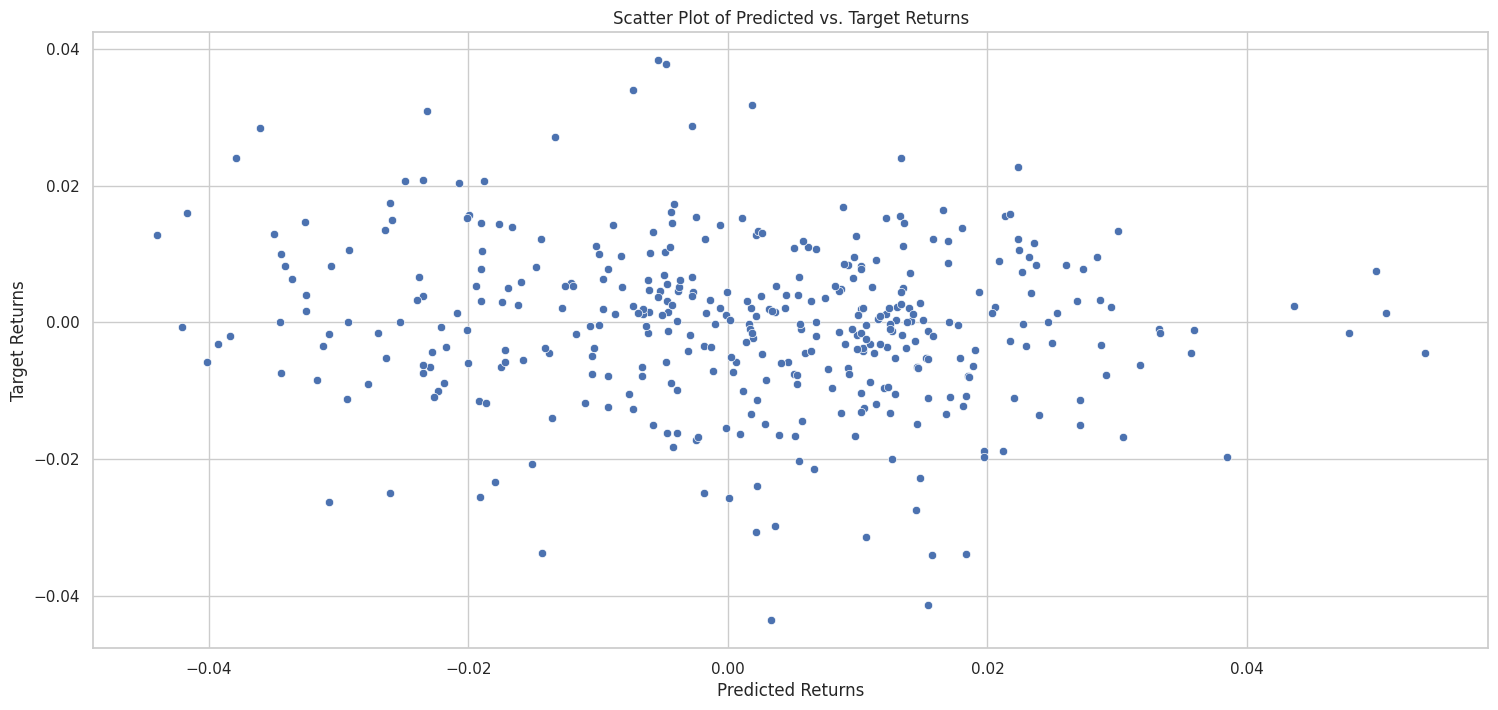

In [ ]:
sns.scatterplot(x = predicted_values[:,0], y = target_values[:,0])
plt.xlabel("Predicted Returns")
plt.ylabel("Target Returns")
plt.title("Scatter Plot of Predicted vs. Target Returns")
plt.show()

Text(0.5, 1.0, 'Cumulative Returns over Time')

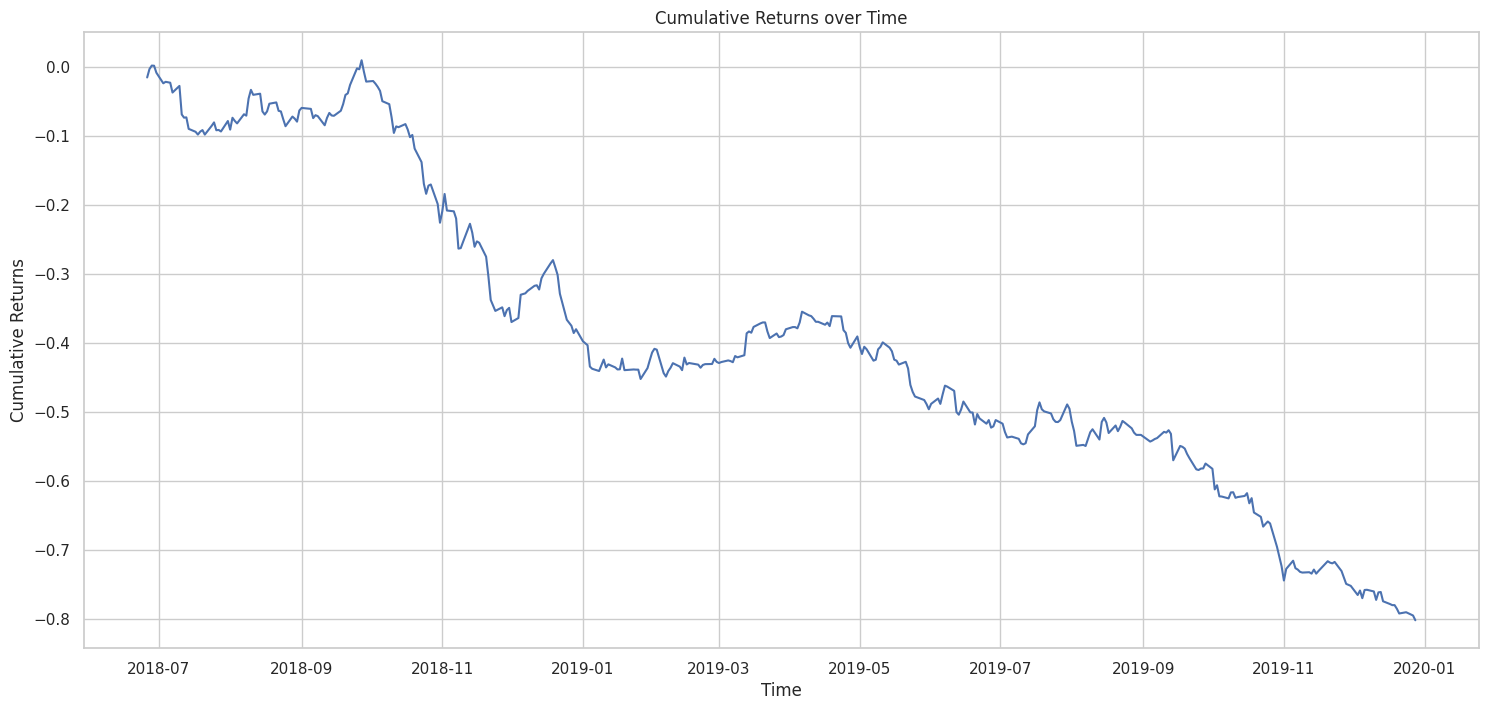

In [ ]:
Returns = pd.Series(np.cumsum(np.sign(predicted_values[:,0]) * target_values[:,0]))
sns.lineplot(x = Dataset.DateTime, y = Returns)
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns over Time")

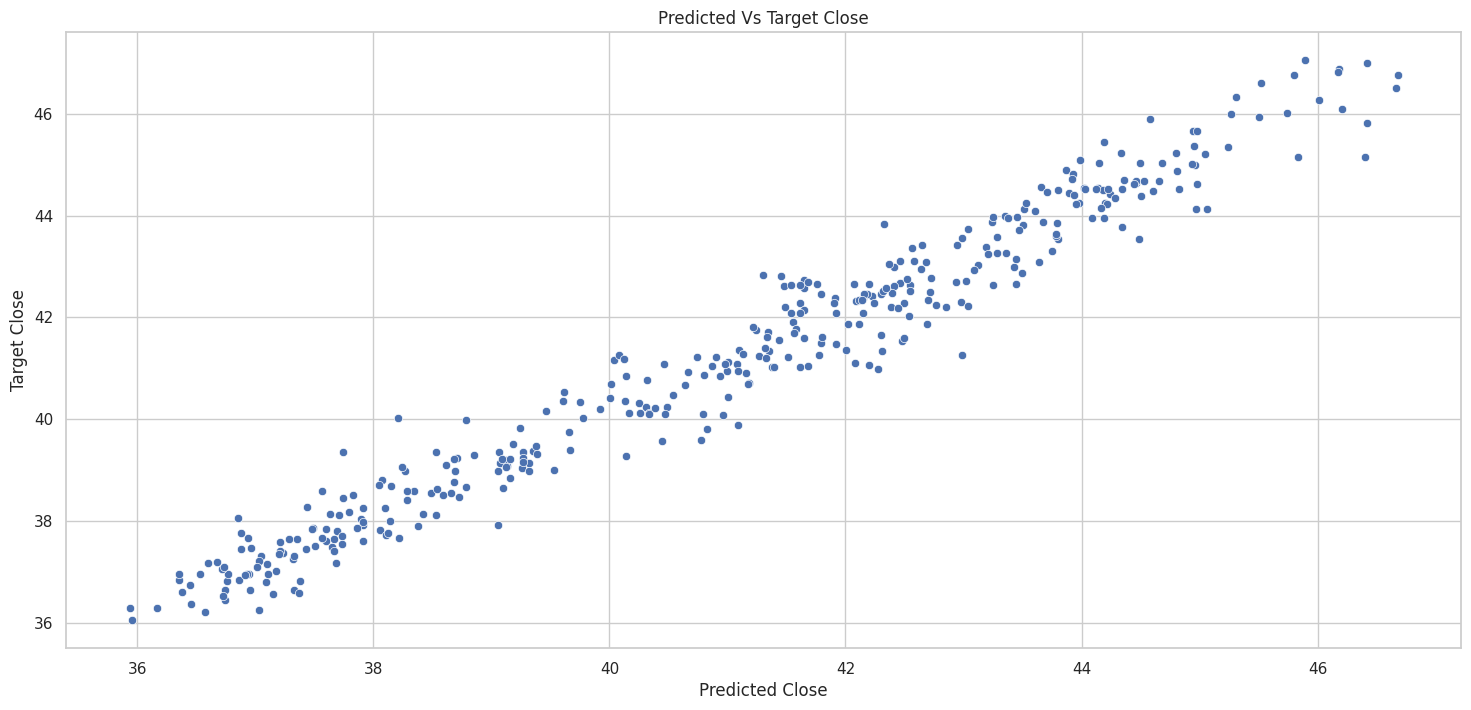

In [ ]:
sns.scatterplot(x = predicted_values[:,1], y = target_values[:,1])
plt.xlabel("Predicted Close")
plt.ylabel("Target Close")
plt.title("Predicted Vs Target Close")
plt.show()

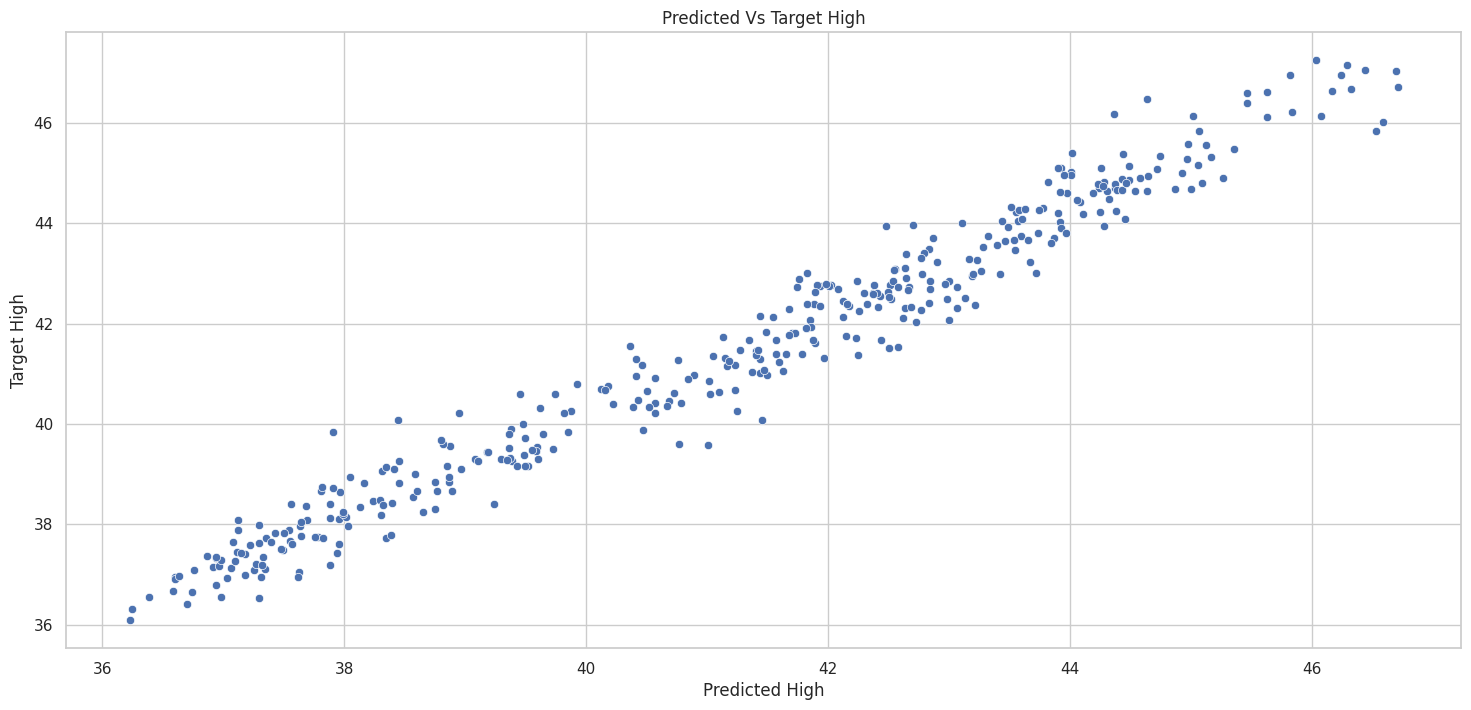

In [ ]:
sns.scatterplot(x = predicted_values[:,2], y = target_values[:,2])
plt.xlabel("Predicted High")
plt.ylabel("Target High")
plt.title("Predicted Vs Target High")
plt.show()

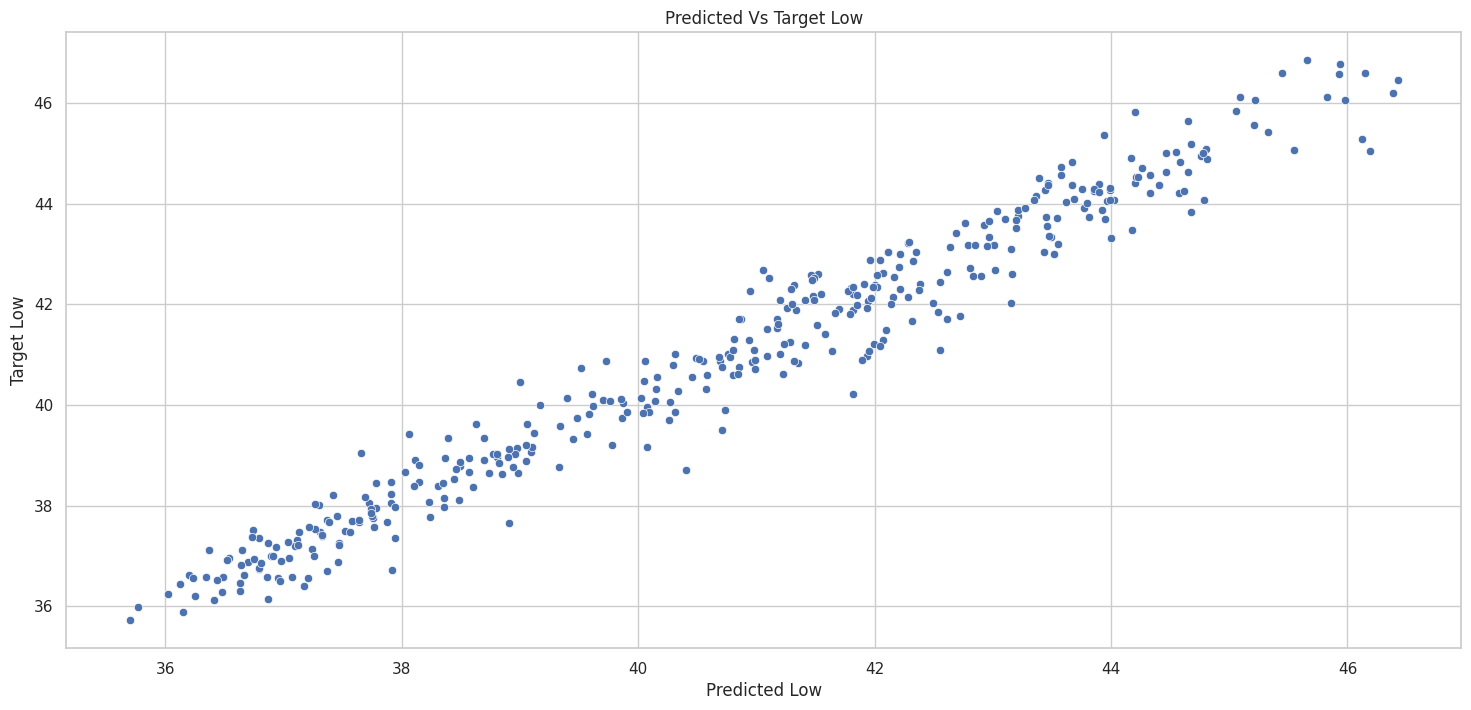

In [ ]:
sns.scatterplot(x = predicted_values[:,3], y = target_values[:,3])
plt.xlabel("Predicted Low")
plt.ylabel("Target Low")
plt.title("Predicted Vs Target Low")
plt.show()

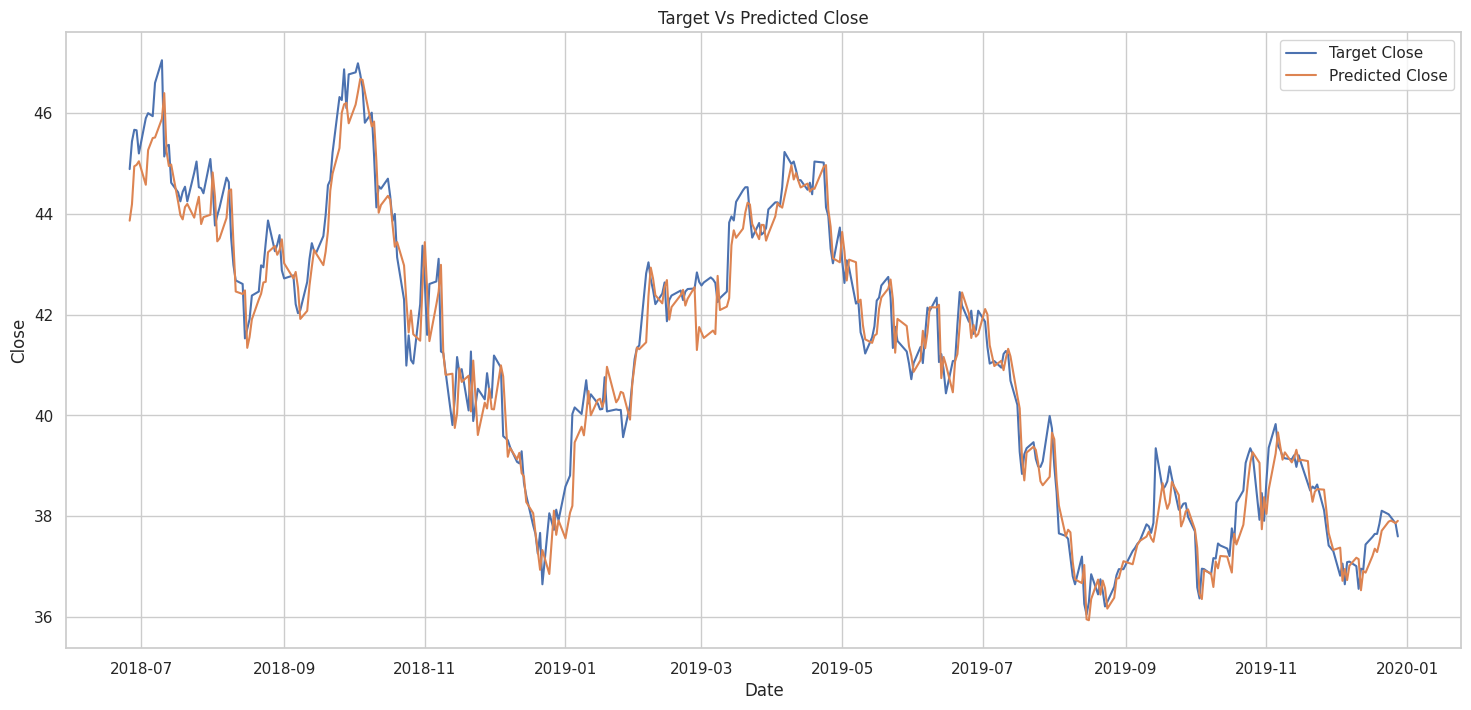

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,1], label = "Target Close")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,1], label = "Predicted Close")

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Target Vs Predicted Close')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,1] , target_values[:,1]))
print(calculate_metrics(np.roll(target_values[:,1],1), target_values[:,1]))

(0.30263698, 0.5501245, 0.42578384, 0.9593650263052046, 1.0341077111661434)
(0.38014597, 0.6165598, 0.3816273, 0.9510140034757087, 0.9313877671957016)


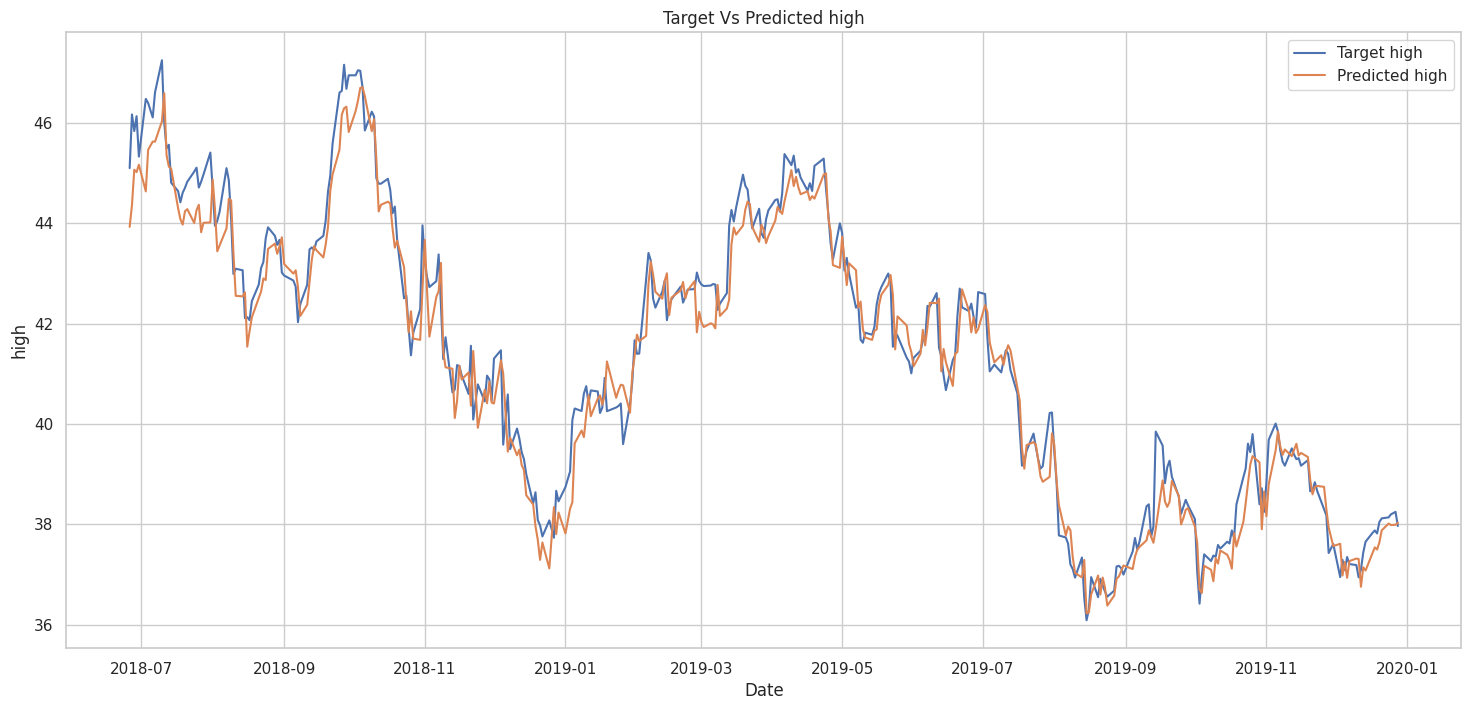

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,2], label = "Target high")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,2], label = "Predicted high")

plt.xlabel('Date')
plt.ylabel('high')
plt.title('Target Vs Predicted high')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,2] , target_values[:,2]))
print(calculate_metrics(np.roll(target_values[:,2],1), target_values[:,2]))

(0.30143785, 0.5490336, 0.42610782, 0.9585497414658437, 1.0301928035914898)
(0.37377742, 0.61137336, 0.3819182, 0.9519378237647999, 0.9261419996619225)


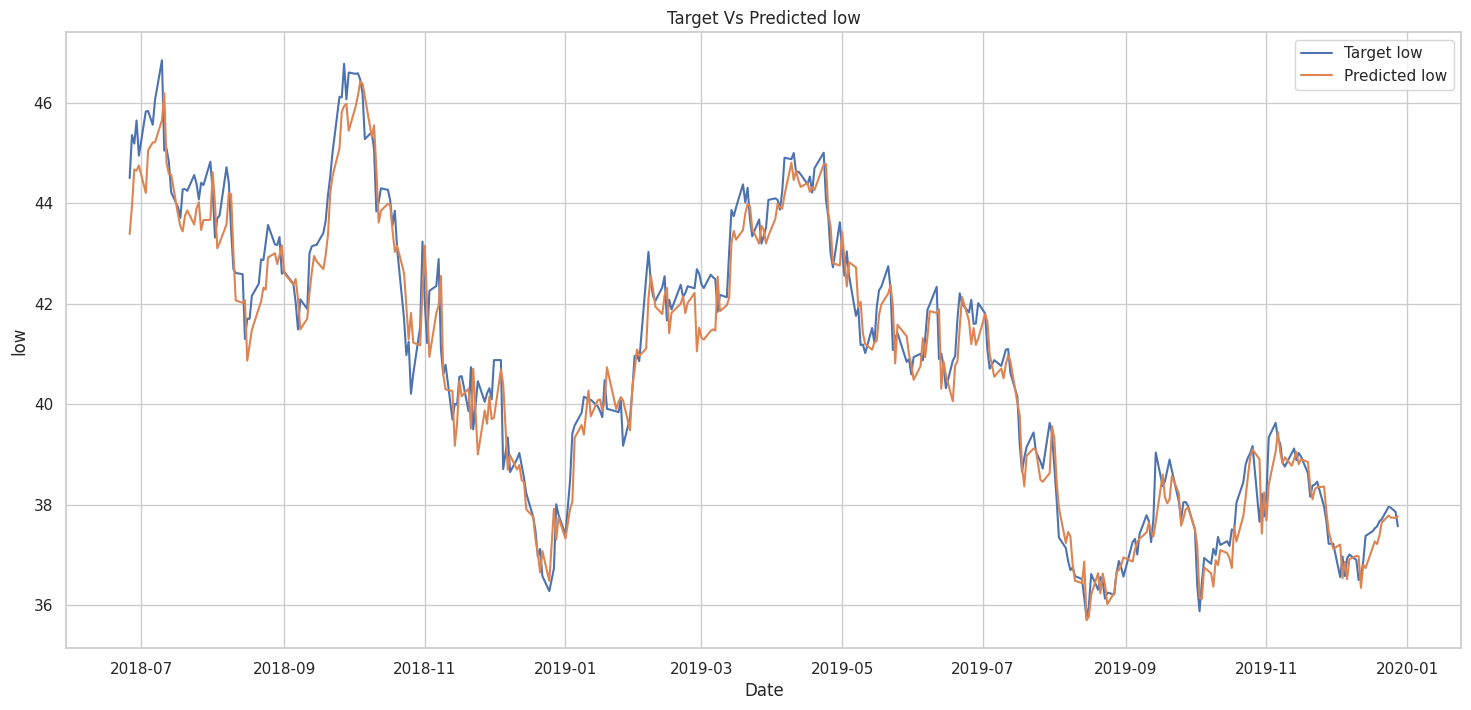

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,3], label = "Target low")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,3], label = "Predicted low")

plt.xlabel('Date')
plt.ylabel('low')
plt.title('Target Vs Predicted low')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,3] , target_values[:,3]))
print(calculate_metrics(np.roll(target_values[:,3],1), target_values[:,3]))

(0.32101965, 0.56658596, 0.4424009, 0.9556333427604836, 1.078751590102911)
(0.39734516, 0.6303532, 0.40606228, 0.9487745520529575, 0.995219312608242)
